# Sep 28th, 2021

**Motivation**: 0.1 and 0.2 <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import Allen
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from register.atlas import Allen

In [3]:
mice = Mice(Config(17, resolution=25), load_preproc=True)

In [4]:
{k: sys.getsizeof(v) for k, v in mice.parcel.results.items()}

{
    'cortex': 136,
    'cortex_eroded': 136,
    'cortex_centers': 1176,
    'radius': 32,
    'n_cortical_regions': 28,
    'subcortex': 136,
    'major_masks': 440,
    'major_colors': 1176,
    'cmap': 48
}

<matplotlib.image.AxesImage object at 0x7fba90b45fd0>

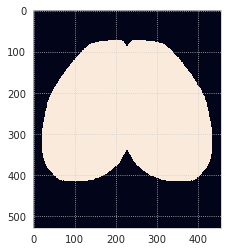

In [4]:
isocortex2d = mice.al.get_masks(315).mean(1, keepdims=True).astype(bool)
plt.imshow(isocortex2d.squeeze())

In [5]:
from register.parcellation import _do_kmeans, kmeans_parcellation
from scipy.spatial import ConvexHull

In [6]:
isocortex2d = mice.al.get_masks(315).mean(1, keepdims=True).astype(bool)
plt.imshow(isocortex2d.squeeze())
parc_output = kmeans_parcellation(isocortex2d, 100, symmetrize=True)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


<matplotlib.image.AxesImage object at 0x7fba83bb2ac0>

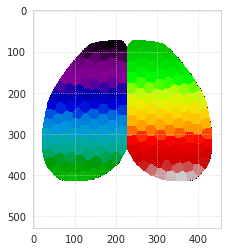

In [7]:
plt.imshow(np.ma.masked_where(~isocortex2d.squeeze(), parc_output['parcel'].squeeze()), cmap='nipy_spectral')

<matplotlib.image.AxesImage object at 0x7fba83c192b0>

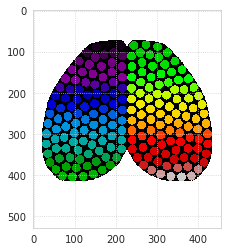

In [8]:
plt.imshow(np.ma.masked_where(~isocortex2d.squeeze(), parc_output['eroded'].squeeze()), cmap='nipy_spectral')

In [9]:
parc_output['parcel'].shape, parc_output['radius']

((528, 1, 456), 10.495970987199604)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


<matplotlib.image.AxesImage object at 0x7edc147a9610>

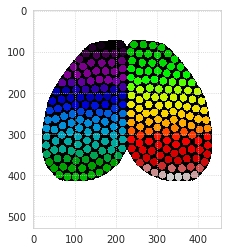

In [48]:
parc_output = kmeans_parcellation(isocortex2d, 128, symmetrize=True)
plt.imshow(np.ma.masked_where(~isocortex2d.squeeze(), parc_output['eroded'].squeeze()), cmap='nipy_spectral')

<matplotlib.image.AxesImage object at 0x7edc147b4550>

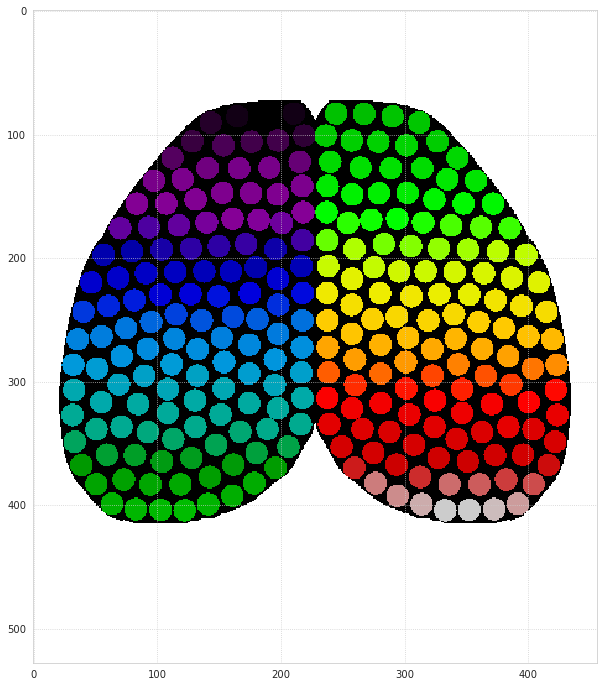

In [49]:
plt.figure(figsize=(15, 12))
plt.imshow(np.ma.masked_where(~isocortex2d.squeeze(), parc_output['eroded'].squeeze()), cmap='nipy_spectral')

In [50]:
data = parc_output['eroded'].squeeze()
data[data > 0] += 100

<matplotlib.image.AxesImage object at 0x7edbf46a04c0>

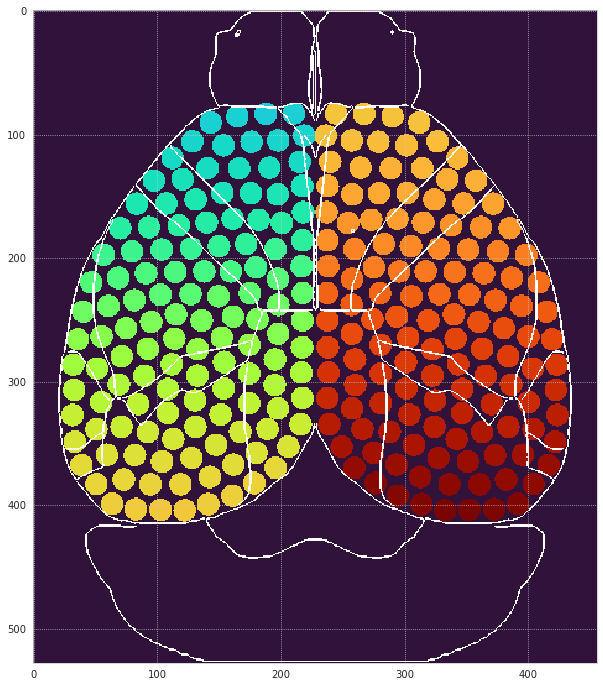

In [51]:
plt.figure(figsize=(15, 12))
plt.imshow(
    np.ma.masked_where(mice.parcel.results2d['contour'], data),#parc_output['eroded'].squeeze()),
    cmap='turbo')

In [58]:
list(mice.parcel.results)

[
    'cortex',
    'cortex_eroded',
    'cortex_centers',
    'radius',
    'n_cortical_regions',
    'subcortex',
    'major_masks',
    'major_colors',
    'cmap'
]

In [60]:
import ants

In [108]:
a = '/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-20/masks'
yek = ants.image_read(pjoin(a, 'sub-SLC01_ses-1_space-CCF-3d_iso-inv.nii.gz'))

In [79]:
dow = mice.T1w['sub-SLC01_ses-1'].load_ants()

In [84]:
img = nib.load(pjoin('/home/hadi/Downloads', 'sub-SLC01_ses-1_space-individual_T1w.nii.gz'))

In [85]:
img.header

<nibabel.nifti1.Nifti1Header object at 0x7edbc41e4a00>

In [89]:
yek_fixed = nib.Nifti1Image(yek.numpy(), affine=None, header=img.header)

In [86]:
yek.numpy().shape

(64, 64, 78)

In [90]:
nib.save(yek_fixed, pjoin('/home/hadi/Downloads', 'sub-SLC01_ses-1_FIXED.nii.gz'))

In [94]:
indiv = mice.T1w['sub-SLC01_ses-1'].load_ants()
mask = mice.mask3d['sub-SLC01_ses-1'].load_ants()

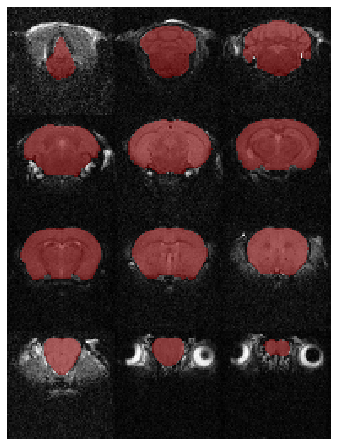

In [98]:
indiv.plot(overlay=mask, axis=2, overlay_alpha=0.6)

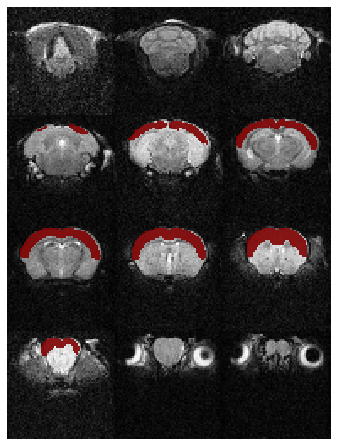

In [100]:
indiv.plot(overlay=yek, axis=2)

In [102]:
indiv_masked = indiv * mask

In [109]:
yek.shape

(64, 64, 78)

In [115]:
yek_fix = yek[::-1]

In [116]:
from register.register import reset_ants_img

In [117]:
yek_fix = reset_ants_img(yek_fix, yek.origin, yek.spacing, 'uint32', False)

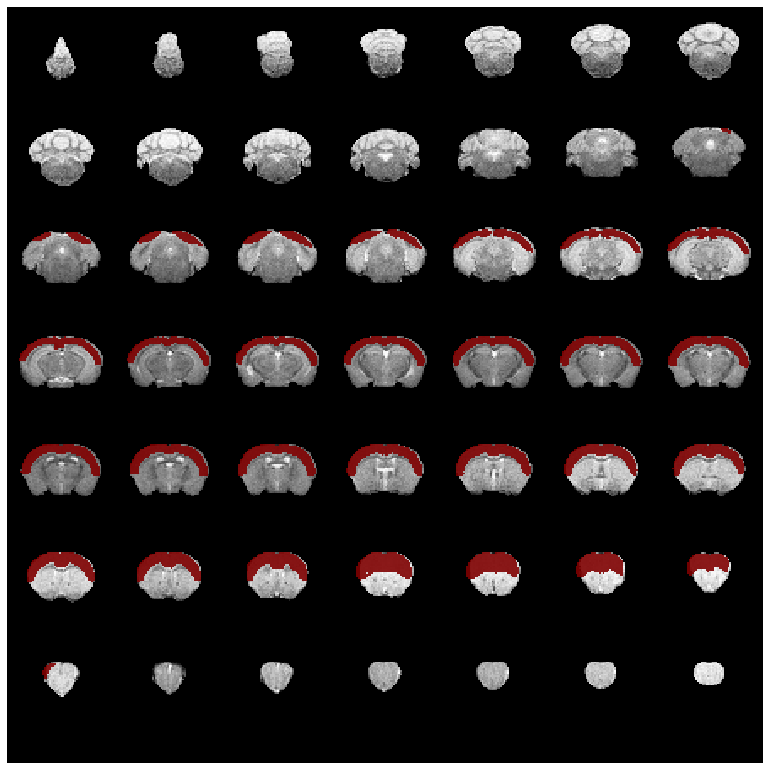

In [118]:
indiv_masked.plot(overlay=yek, axis=2, nslices=49)

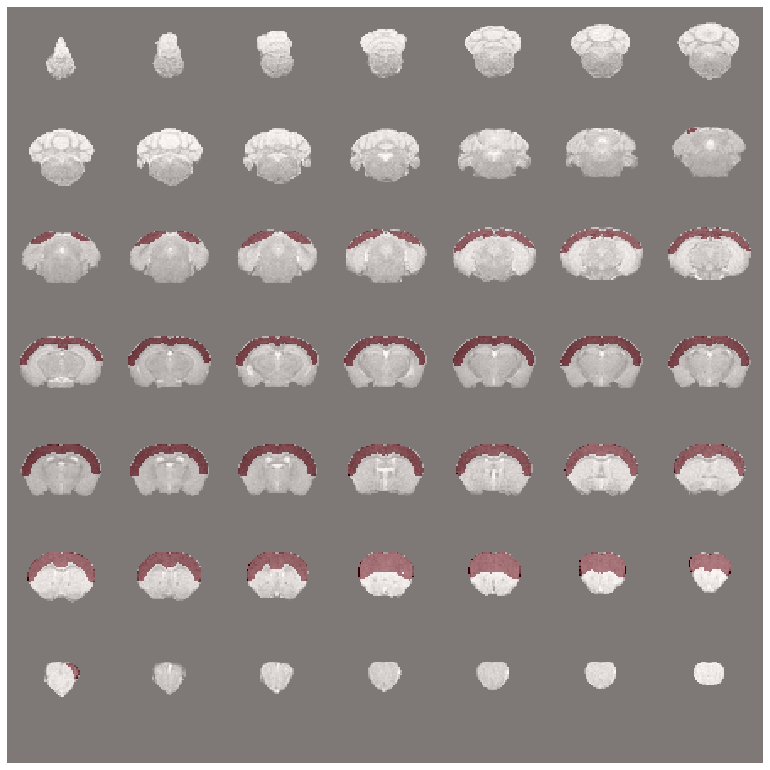

In [121]:
indiv_masked.plot(overlay=yek_fix, axis=2, nslices=49, overlay_cmap='Reds', overlay_alpha=0.5)

In [127]:
a = np.arange(30).reshape(2, 3, 5)
a

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]],

       [[15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29]]])

In [128]:
b = a[::-1, :, ::-1]
b

array([[[19, 18, 17, 16, 15],
        [24, 23, 22, 21, 20],
        [29, 28, 27, 26, 25]],

       [[ 4,  3,  2,  1,  0],
        [ 9,  8,  7,  6,  5],
        [14, 13, 12, 11, 10]]])

In [129]:
c = a[..., ::-1]
c = a[::-1]
c

array([[[15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29]],

       [[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]]])

In [52]:
sizes = []
x = parc_output['eroded'].squeeze()
for i in np.unique(x[x > 0]):
    sizes.append((x == i).sum())

<AxesSubplot:ylabel='Count'>

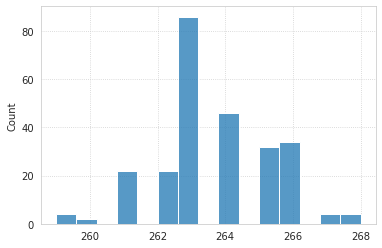

In [53]:
sns.histplot(sizes)

In [54]:
collections.Counter(sizes)

Counter({
    265: 32,
    263: 86,
    264: 46,
    266: 34,
    261: 22,
    260: 2,
    262: 22,
    267: 4,
    259: 4,
    268: 4
})

In [21]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
rng = np.random.default_rng()
points = rng.random((30, 2))   # 30 random points in 2-D
points *= 100
com = (points[:, 0].mean(), points[:, 1].mean())
hull = ConvexHull(points)
remove = hull.simplices.ravel()
remove = list(set(set(remove)))

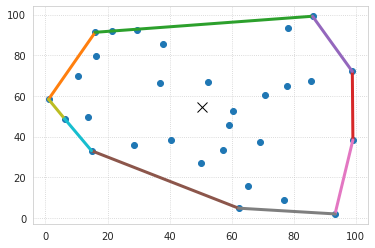

In [22]:
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(com[0], com[1], 'x', markersize=10, color='k')
for i, simplex in enumerate(hull.simplices):
    plt.plot(points[simplex, 0], points[simplex, 1], f"C{i+1}", lw=3)
plt.show()

In [23]:
keep = np.delete(range(len(points)), remove)

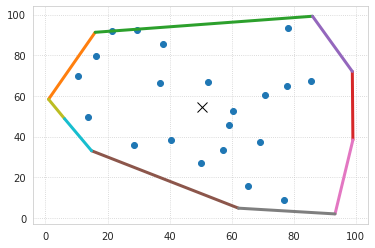

In [24]:
plt.plot(points[keep, 0], points[keep, 1], 'o')
plt.plot(com[0], com[1], 'x', markersize=10, color='k')
for i, simplex in enumerate(hull.simplices):
    plt.plot(points[simplex, 0], points[simplex, 1], f"C{i+1}", lw=3)
plt.show()

In [428]:
radius = 20
boundary = []
for i, simplex in enumerate(points[hull.simplices]):
    a, b = simplex
    arrow = 2 * np.array(com) - (a + b)
    arrow = arrow / np.linalg.norm(arrow)
    arrow = np.ceil(arrow) - np.ceil(-arrow)
    arrow = arrow / np.linalg.norm(arrow)
    a += radius * arrow
    b += radius * arrow
    ab = np.concatenate([[a], [b]])
    boundary.append(np.expand_dims(ab, axis=0))
boundary = np.concatenate(boundary)
boundary.shape

(8, 2, 2)

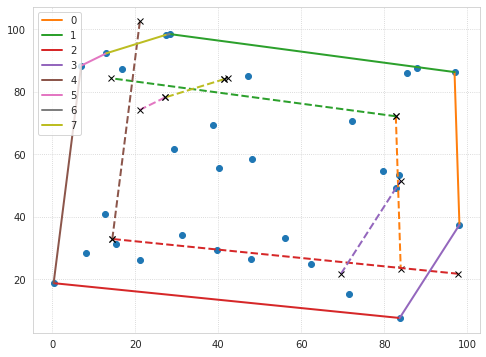

In [429]:
simplices = points[hull.simplices]

radius = 10

plt.figure(figsize=(8, 6))
plt.plot(points[:, 0], points[:, 1], 'o')

for i, simplex in enumerate(simplices):
    x, y = simplex.T
    plt.plot(x, y, f"C{i+1}", lw=2, ls='-', label=i)
    
    x, y = boundary[i].T
    plt.plot(x, y, f"C{i+1}", lw=2, ls='--')
    
    a, b = boundary[i]
    plt.plot(boundary[i][:, 0], boundary[i][:, 1], 'x', color='k')
    
plt.legend()
plt.show()

In [415]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [423]:
boundary_points = []
for i, j in itertools.combinations(range(len(boundary)), 2):
    point = line_intersection(boundary[i].T, boundary[j].T)
    if point is not None:
        boundary_points.append(point)
boundary_points = list(set(boundary_points))
boundary_points = np.array(boundary_points)

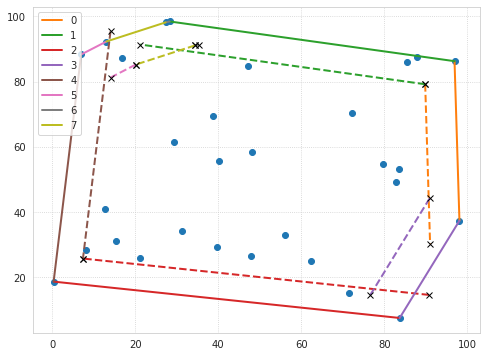

In [424]:
simplices = points[hull.simplices]

radius = 10

plt.figure(figsize=(8, 6))
plt.plot(points[:, 0], points[:, 1], 'o')

for i, simplex in enumerate(simplices):
    x, y = simplex.T
    plt.plot(x, y, f"C{i+1}", lw=2, ls='-', label=i)
    
    x, y = boundary[i].T
    plt.plot(x, y, f"C{i+1}", lw=2, ls='--')
    
    a, b = boundary[i]
    plt.plot(boundary[i][:, 0], boundary[i][:, 1], 'x', color='k')
    
plt.legend()
plt.show()

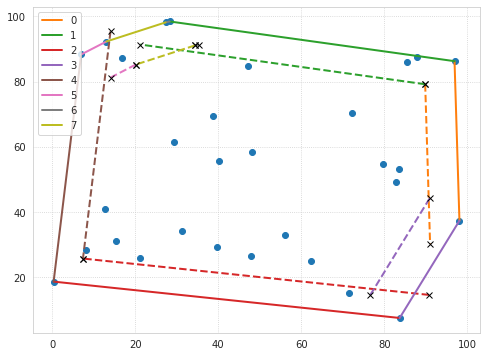

In [427]:
simplices = points[hull.simplices]

radius = 10

plt.figure(figsize=(8, 6))
plt.plot(points[:, 0], points[:, 1], 'o')
# plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'x', color='r')

for i, simplex in enumerate(simplices):
    x, y = simplex.T
    plt.plot(x, y, f"C{i+1}", lw=2, ls='-', label=i)
    
    x, y = boundary[i].T
    plt.plot(x, y, f"C{i+1}", lw=2, ls='--')
    
    a, b = boundary[i]
    plt.plot(boundary[i][:, 0], boundary[i][:, 1], 'x', color='k')

plt.legend()
plt.show()

In [422]:
np.array(boundary_points).shape

(28, 2)

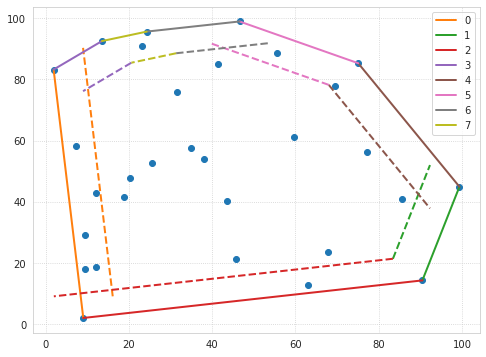

In [367]:
simplices = points[hull.simplices]

radius = 10

plt.figure(figsize=(8, 6))
plt.plot(points[:, 0], points[:, 1], 'o')

arrows = {}
for i, simplex in enumerate(simplices):
    x, y = simplex.T
    plt.plot(x, y, f"C{i+1}", lw=2, ls='-', label=i)

    a, b = simplex
    arrow = 2 * np.array(com) - (a + b)
    arrow = arrow / np.linalg.norm(arrow)
    arrow = np.ceil(arrow) - np.ceil(-arrow)
    arrow = arrow / np.linalg.norm(arrow)

    a += radius * arrow
    b += radius * arrow
    ab = np.concatenate([[a], [b]]).T
    plt.plot(ab[0], ab[1], f"C{i+1}", lw=2, ls='--')
    
plt.legend()
plt.show()

In [366]:
ab.shape


(2, 2)

In [360]:
ab

array([31.35141101, 88.50117429, 20.60296386, 85.40795281])

In [336]:
simplices

array([[[ 9.05386249,  2.04118543],
        [ 1.92979216, 83.18989948]],

       [[90.4844839 , 14.31420877],
        [99.38422313, 44.90933881]],

       [[90.4844839 , 14.31420877],
        [ 9.05386249,  2.04118543]],

       [[13.53189604, 92.47902062],
        [ 1.92979216, 83.18989948]],

       [[75.08074738, 85.24251858],
        [99.38422313, 44.90933881]],

       [[75.08074738, 85.24251858],
        [46.58080177, 98.88337715]],

       [[24.2803432 , 95.57224211],
        [46.58080177, 98.88337715]],

       [[24.2803432 , 95.57224211],
        [13.53189604, 92.47902062]]])

array([[ 9.05386249,  2.04118543],
       [ 1.92979216, 83.18989948]])

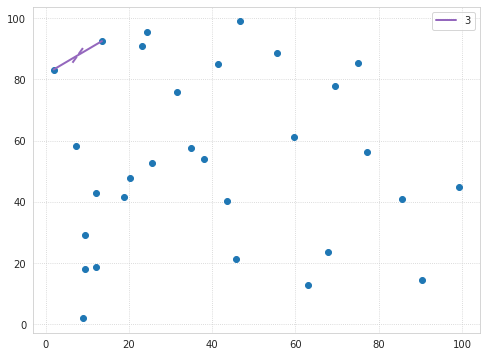

In [318]:
radius = 10

plt.figure(figsize=(8, 6))
plt.plot(points[:, 0], points[:, 1], 'o')

arrows = {}
for i, simplex in enumerate(hull.simplices):
    if i != 3:
        continue
    else:
        a, b = points[simplex].T
        arrow = 2 * np.array(com) - (a + b)
        arrow = arrow / np.linalg.norm(arrow)
        arrow = np.ceil(arrow) - np.ceil(-arrow)
        arrow = arrow / np.linalg.norm(arrow)

        plt.plot(a, b, f"C{i+1}", lw=2, ls='-', label=i)
        plt.plot(a + radius * arrow, b + radius * arrow, f"C{i+1}", lw=2, ls='--')
plt.legend()
plt.show()

In [319]:
a, b

(array([13.53189604,  1.92979216]), array([92.47902062, 83.18989948]))

In [320]:
points[hull.simplices]

array([[[ 9.05386249,  2.04118543],
        [ 1.92979216, 83.18989948]],

       [[90.4844839 , 14.31420877],
        [99.38422313, 44.90933881]],

       [[90.4844839 , 14.31420877],
        [ 9.05386249,  2.04118543]],

       [[13.53189604, 92.47902062],
        [ 1.92979216, 83.18989948]],

       [[75.08074738, 85.24251858],
        [99.38422313, 44.90933881]],

       [[75.08074738, 85.24251858],
        [46.58080177, 98.88337715]],

       [[24.2803432 , 95.57224211],
        [46.58080177, 98.88337715]],

       [[24.2803432 , 95.57224211],
        [13.53189604, 92.47902062]]])

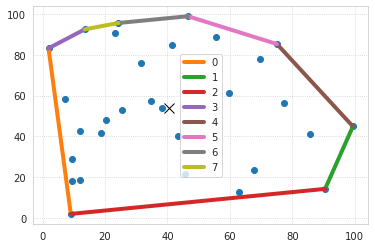

In [294]:
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(com[0], com[1], 'x', markersize=10, color='k')
for j, simplex in enumerate(hull.simplices):
    plt.plot(points[simplex, 0], points[simplex, 1], f"C{j+1}", lw=4, ls='-', label=j)
plt.legend()
plt.show()

In [303]:
arrows[3]

array([-0.70710678,  0.70710678])

In [296]:
arrows[7]

array([-0.70710678,  0.70710678])

In [307]:
a, b = points[hull.simplices[3]].T
arrow = 2 * np.array(com) - (a + b)
arrow = arrow / np.linalg.norm(arrow)
arrow = np.ceil(arrow) - np.ceil(-arrow)
arrow = arrow / np.linalg.norm(arrow)
arrow

array([-0.70710678,  0.70710678])

In [308]:
a, b

(array([13.53189604,  1.92979216]), array([92.47902062, 83.18989948]))

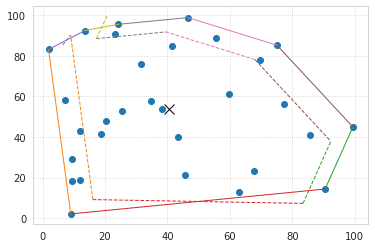

In [299]:
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(com[0], com[1], 'x', markersize=10, color='k')
for j, simplex in enumerate(hull.simplices):
    a, b = points[simplex, 0], points[simplex, 1]
    plt.plot(a, b, f"C{j+1}", lw=1, ls='-')
    plt.plot(a + radius * arrows[j], b + radius * arrows[j], f"C{j+1}", lw=1, ls='--')

[90.4844839   9.05386249] [14.31420877  2.04118543]

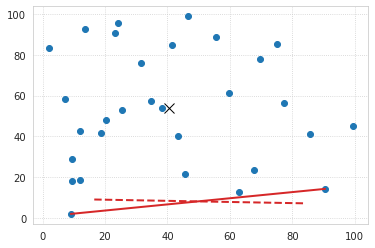

In [235]:
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(com[0], com[1], 'x', markersize=10, color='k')
for j, simplex in enumerate(hull.simplices):
    if j != 2:
        continue
    a, b = points[simplex, 0], points[simplex, 1]
    print(a, b)
    plt.plot(a, b, f"C{j+1}", lw=2, ls='-')
    plt.plot(a + radius * arrows[j], b + radius * arrows[j], f"C{j+1}", lw=2, ls='--')

In [247]:
a + radius * arrows[2], b + radius * arrows[2]

(array([17.20927539, 20.60296386]), array([88.50117429, 99.55008843]))

In [246]:
arrows[2]

array([-0.70710678,  0.70710678])

In [240]:
simplex = hull.simplices[2]

In [241]:
points[simplex[0]], points[simplex[1]]

(array([90.4844839 , 14.31420877]), array([9.05386249, 2.04118543]))

In [234]:
arrows[2]

array([-0.70710678,  0.70710678])

In [221]:
hull.simplices

array([[20, 19],
       [12, 11],
       [12, 20],
       [ 5, 19],
       [13, 11],
       [13, 29],
       [21, 29],
       [21,  5]], dtype=int32)

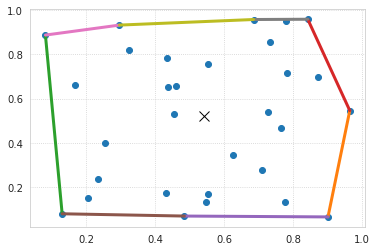

In [133]:
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(ctr[0], ctr[1], 'x', markersize=10, color='k')
for i, simplex in enumerate(hull.simplices):
    plt.plot(points[simplex, 0], points[simplex, 1], f"C{i+1}", lw=3)
plt.show()

In [138]:
hull.simplices.shape, points.shape

((8, 2), (30, 2))

In [139]:
hull.simplices

array([[12, 28],
       [ 0, 15],
       [17, 28],
       [19, 12],
       [19,  0],
       [14, 15],
       [ 9, 17],
       [ 9, 14]], dtype=int32)

In [440]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
rng = np.random.default_rng()
points = rng.random((30, 2)) * 100
com = np.array([points[:, 0].mean(), points[:, 1].mean()])

In [441]:
tri = Delaunay(points)

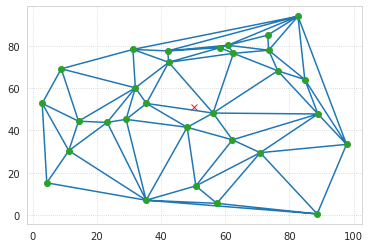

In [445]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(com[0], com[1], 'x')
plt.show()

In [444]:
tri.plane_distance(com)

array([-19.51621573,  -8.00726929,  -5.13585176,  -9.42482497,
       -20.67071309, -11.89963412,  -4.1373896 ,  -4.20023712,
        -2.21623566, -47.08379575,  -7.85495092, -14.81482613,
        -4.78504878,  -2.26883945,   0.23945638,  -3.31013838,
        -3.50898673,  -6.03524089,  -2.85091585,  -3.78617285,
        -0.38238113,  -0.97483127,  -1.73436671,  -2.22612024,
        -0.44412866,   0.43996042,   0.51698602,  -0.07587679,
        -0.20523265,  -0.88368651,  -1.27531032,  -9.1403039 ,
        -1.66491589,  -2.22318414, -10.98612597,  -5.15641499,
        -3.31713967,  -2.63604714,  -4.2891237 ,  -4.24665685,
        -6.0301549 ,  -7.11085646,  -6.92917691,  -2.9410212 ,
       -12.12907307, -11.0596643 ,  -0.55491577,  -3.12643811,
        -2.07537136,  -7.40969076])

In [446]:
tri.convex_hull

array([[ 5,  6],
       [ 2,  6],
       [29,  9],
       [24, 13],
       [24,  9],
       [29, 11],
       [ 2, 13],
       [11,  5]], dtype=int32)

<AxesSubplot:ylabel='Count'>

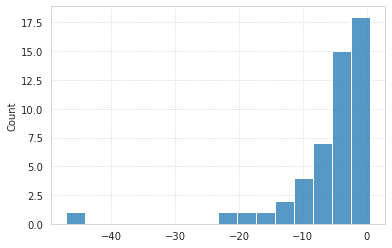

In [447]:
sns.histplot(tri.plane_distance(com))

In [461]:
points = np.where(mice.parcel.results2d['cortex'] == 25)
points = np.array(tuple(zip(*points)))
com = points.mean(0)

In [462]:
points

array([[179, 308],
       [179, 309],
       [179, 310],
       ...,
       [256, 363],
       [256, 364],
       [256, 365]])

[<matplotlib.lines.Line2D object at 0x7edb9dc0ea60>]

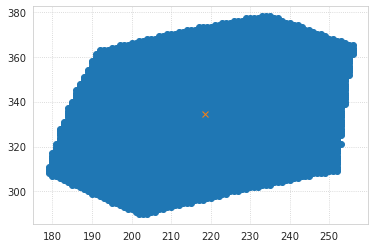

In [463]:
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(com[0], com[1], 'x')

In [464]:
hull = ConvexHull(points)
# simplices = points[hull.simplices]

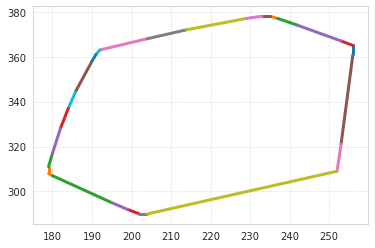

In [465]:
# plt.plot(points[:, 0], points[:, 1], 'o', alpha=0.2)
# plt.plot(ctr[0], ctr[1], 'x', markersize=10, color='k')
for i, simplex in enumerate(hull.simplices):
    plt.plot(points[simplex, 0], points[simplex, 1], f"C{i+1}", lw=3)
plt.show()

In [455]:
len(hull.simplices)

26

In [456]:
len(points)

5029

In [459]:
hull.simplices.ravel()

array([   4,    0,    4,  672,  957, 1182,  957,  672, 4938, 5024, 4938,
       4879, 1338, 1182, 1338, 4879,  194,  113, 5028, 5024,    3,    0,
          3,   14,   52,  113,   52,   14,  407,  194, 1416,  536, 1416,
       2194, 3350, 2194,  470,  536,  470,  407, 3954, 3806, 3954, 4307,
       4981, 5028, 4981, 4307, 3654, 3806, 3654, 3350], dtype=int32)

In [466]:
tri = Delaunay(points)

In [482]:
np.quantile(plane_dists, 0.1)

-1.9363020274761482

In [488]:
plane_dists = tri.plane_distance(com)

<AxesSubplot:ylabel='Count'>

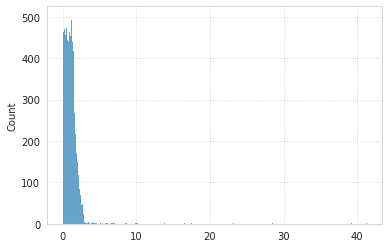

In [489]:
sns.histplot(np.abs(plane_dists))

In [490]:
np.quantile(np.abs(plane_dists), 0.9)

1.9363020274761473

In [491]:
remove = []
for simplex, dist in zip(tri.simplices, plane_dists):
    if abs(dist) > np.quantile(np.abs(plane_dists), 0.9):
        remove.extend(list(simplex))
remove = list(set(remove))
len(remove)

624

[<matplotlib.lines.Line2D object at 0x7edb9cb1d130>]

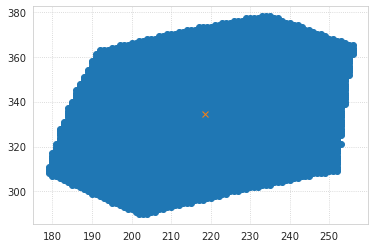

In [492]:
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(com[0], com[1], 'x')

[<matplotlib.lines.Line2D object at 0x7edb9cae2520>]

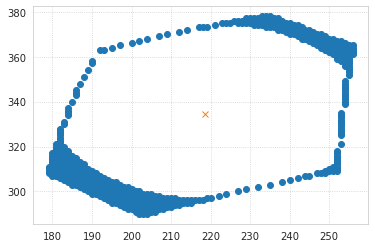

In [493]:
plt.plot(points[remove, 0], points[remove, 1], 'o')
plt.plot(com[0], com[1], 'x')

In [3]:
mice = Mice(Config(256, resolution=100))
from register.parcellation import kmeans_parcellation

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


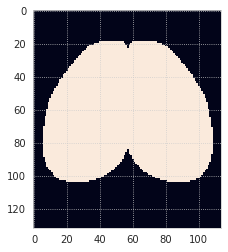

In [4]:
isocortex2d = mice.al.get_masks(315).mean(1, keepdims=True).astype(bool)
plt.imshow(isocortex2d.squeeze())

parc_output = kmeans_parcellation(isocortex2d, 256, symmetrize=True)

In [15]:
mice = Mice(Config(17, resolution=25))

[PROGRESS] 'config.json' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-17

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


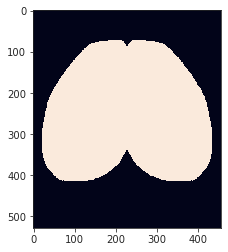

In [17]:
isocortex2d = mice.al.get_masks(315).mean(1, keepdims=True).astype(bool)
plt.imshow(isocortex2d.squeeze())

parc_output = kmeans_parcellation(isocortex2d, 256, symmetrize=True)

<matplotlib.image.AxesImage object at 0x7f38e35a7400>

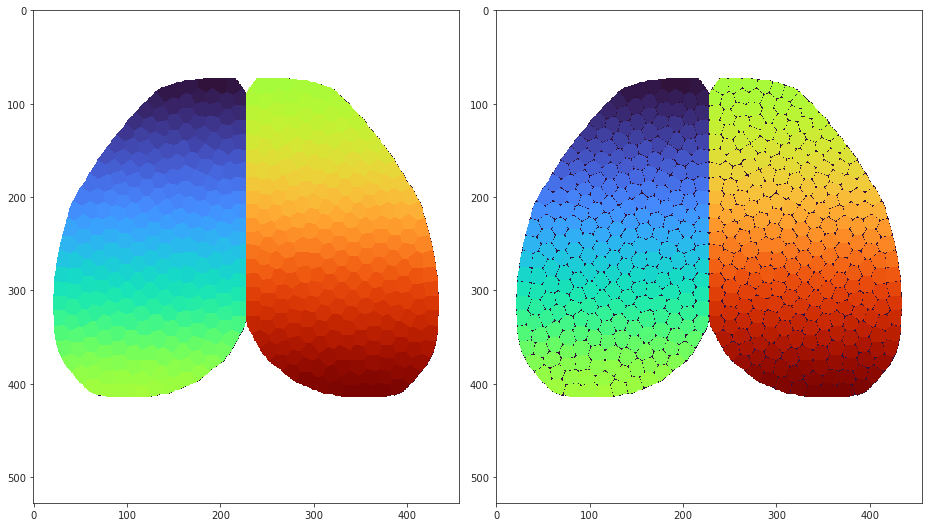

In [18]:
fig, axes = create_figure(1, 2, (13, 15))
axes[0].imshow(np.ma.masked_where(~isocortex2d.squeeze(), parc_output['parcel'].squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(~isocortex2d.squeeze(), parc_output['eroded'].squeeze()), cmap='turbo')

In [534]:
# radius = 0.95

parcel = parc_output['parcel']
eroded = np.zeros(parcel.squeeze().shape)
for region_i in tqdm(np.unique(parcel[parcel > 0])):
    points = np.where(parcel == region_i)
    points = np.array(tuple(zip(*points)))
    points = points[:, [0, -1]]
    com = points.mean(0)
    
    tri = Delaunay(points)
    plane_dists = tri.plane_distance(com)
    
    # remove = []
    # for simplex, dist in zip(tri.simplices, plane_dists):
    #     if abs(dist) > np.quantile(np.abs(plane_dists), radius):
    #         remove.extend(list(simplex))
    remove = list(set(set(tri.convex_hull.ravel())))
    keep = np.delete(range(len(points)), remove)
    points = points[keep]
    eroded[tuple(zip(*points))] = region_i

  0%|          | 0/512 [00:00<?, ?it/s]

In [33]:
np.arange(15).reshape(3, 5).shape([True, True])

TypeError: 'tuple' object is not callable

<matplotlib.image.AxesImage object at 0x7edb9c0d7d00>

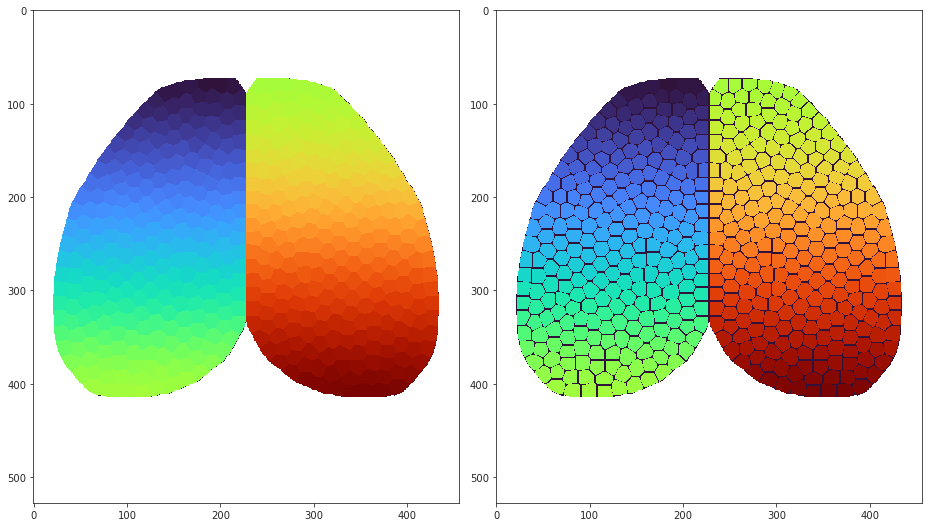

In [541]:
fig, axes = create_figure(1, 2, (13, 15))
axes[0].imshow(np.ma.masked_where(~isocortex2d.squeeze(), parcel.squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(~isocortex2d.squeeze(), eroded.squeeze()), cmap='turbo')

In [3]:
path = '/home/hadi/Documents/workspaces/allen/MouseConnectivity/cortical_coordinates/ccf_2017'
sorted(os.listdir(path))

[
    'dorsal_flatmap_paths_10.h5',
    'isocortex_boundary_10.nrrd',
    'isocortex_mask_10.nrrd',
    'laplacian_10.nrrd',
    'top_view_paths_10.h5'
]

In [4]:
isob, meta = nrrd.read(pjoin(path, 'isocortex_boundary_10.nrrd'))

In [5]:
meta

OrderedDict([('type', 'unsigned short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([1320,  800, 1140])), ('space directions', array([[10.,  0.,  0.],
       [ 0., 10.,  0.],
       [ 0.,  0., 10.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])

In [7]:
np.unique(isob[isob > 0])

array([1, 3, 4], dtype=uint16)

<matplotlib.image.AxesImage object at 0x7f826b6e4ac0>

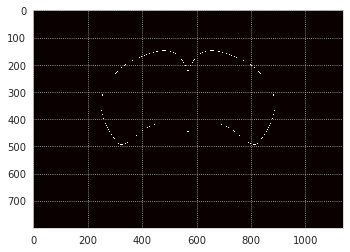

In [21]:
plt.imshow((isob == 1)[300], cmap='hot')

<matplotlib.image.AxesImage object at 0x7f826b6c38e0>

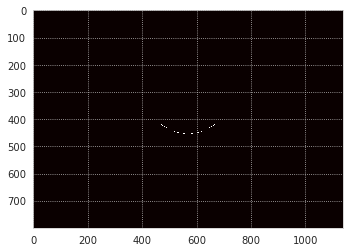

In [22]:
plt.imshow((isob > 1)[300], cmap='hot')

In [23]:
laplacian, laplacian_header = nrrd.read(pjoin(path, 'laplacian_10.nrrd'))

In [25]:
laplacian.shape

(1320, 800, 1140)

<matplotlib.colorbar.Colorbar object at 0x7f8267adfb20>

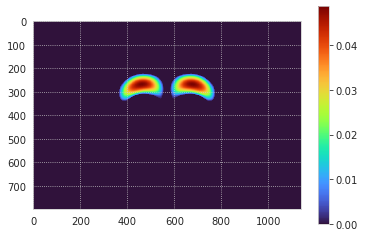

In [86]:
plt.imshow(laplacian[200], cmap='turbo')
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f8268c6be20>

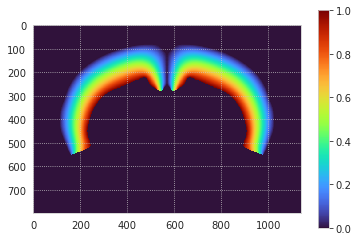

In [46]:
plt.imshow(laplacian[500], cmap='turbo')
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f8268d72fd0>

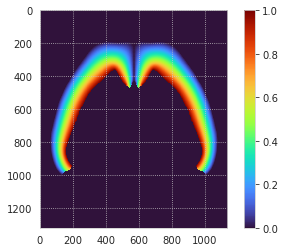

In [45]:
plt.imshow(laplacian[:, 300, :], cmap='turbo')
plt.colorbar()

In [87]:
top = laplacian > 0.9

<matplotlib.image.AxesImage object at 0x7f82679dc160>

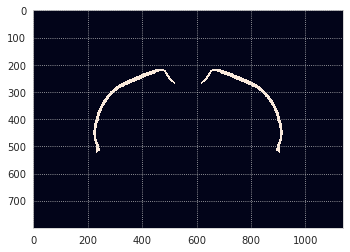

In [89]:
plt.imshow(top[500])

<matplotlib.colorbar.Colorbar object at 0x7f8268382730>

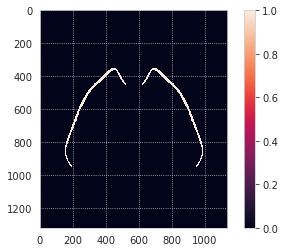

In [67]:
plt.imshow(top[:, 300, :])
plt.colorbar()

In [49]:
np.unique(laplacian[:, 300, :])

array([0.0000000e+00, 2.2161007e-04, 2.4104118e-04, ..., 9.9686170e-01,
       9.9694914e-01, 1.0000000e+00], dtype=float32)

<matplotlib.image.AxesImage object at 0x7edb67894fd0>

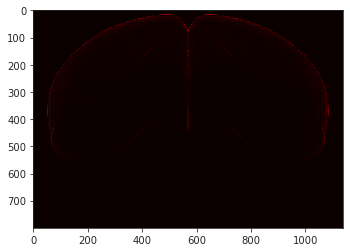

In [555]:
plt.imshow((isob == 1).mean(0), cmap='hot')

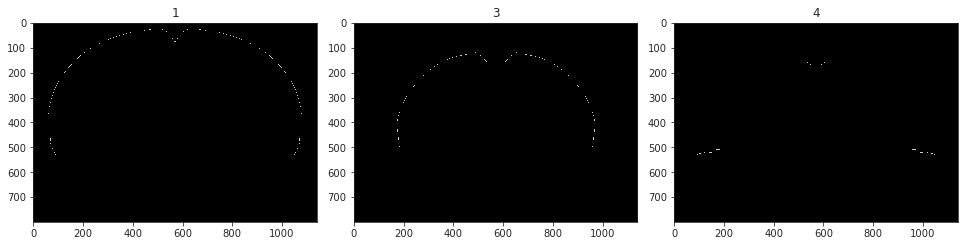

In [90]:
fig, axes = create_figure(1,3,(13.5, 4))
for ax, i in zip(axes.ravel(), [1, 3, 4]):
    ax.imshow((isob == i)[700], cmap='nipy_spectral')
    ax.set_title(i)
plt.show()

<matplotlib.image.AxesImage object at 0x7edb9c480610>

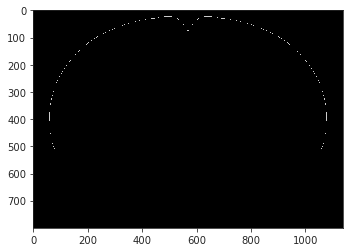

In [568]:
plt.imshow((isob == 1)[700], cmap='nipy_spectral')

<matplotlib.image.AxesImage object at 0x7edb66cbcdc0>

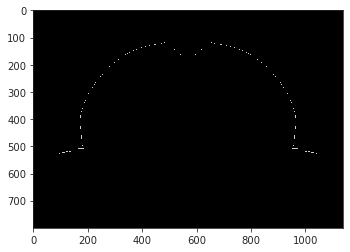

In [569]:
plt.imshow((isob > 1)[700], cmap='nipy_spectral')

In [3]:
%%time
al = Allen(10, full_load=True)

CPU times: user 57.2 s, sys: 37.4 s, total: 1min 34s
Wall time: 1min 36s


In [4]:
al.proj

'top_view'

In [5]:
x = al.cortical_map(al.template, 'dorsal_flatmap', agg_func=np.max)
x.shape

(1360, 2720)

<matplotlib.image.AxesImage object at 0x7f4b15db9640>

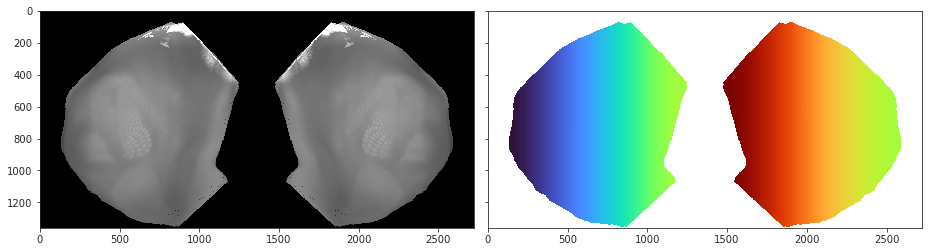

In [6]:
fig, axes = create_figure(1, 2, (13, 6), True, True)
axes[0].imshow(x, cmap='Greys_r')
axes[1].imshow(np.ma.masked_where(al.lookup == 0, al.lookup), cmap='turbo')

In [7]:
x.dtype, x.min(), x.max()

(dtype('uint16'), 0, 516)

<matplotlib.image.AxesImage object at 0x7f4ab4ed2580>

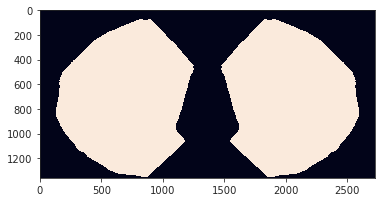

In [8]:
plt.imshow(al.lookup > 0)

In [9]:
from register.parcellation import kmeans_parcellation

In [10]:
%%time
parc = kmeans_parcellation(np.expand_dims(al.lookup > 0, axis=1), 64)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [15]:
save_obj(parc, 'parc_n128', tmp_dir, 'npy')

[PROGRESS] 'parc_n128.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

'/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/parc_n128.npy'

<matplotlib.image.AxesImage object at 0x7f4a0501cc40>

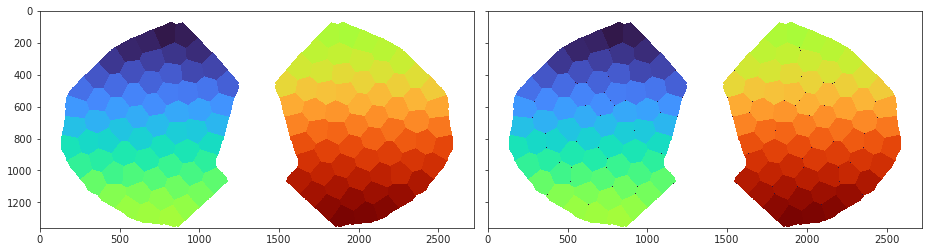

In [16]:
fig, axes = create_figure(1, 2, (13, 6), True, True)
axes[0].imshow(np.ma.masked_where(al.lookup == 0, parc['parcel'].squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(al.lookup == 0, parc['eroded'].squeeze()), cmap='turbo')

[(1500.0, 2200.0), (200.0, 800.0)]

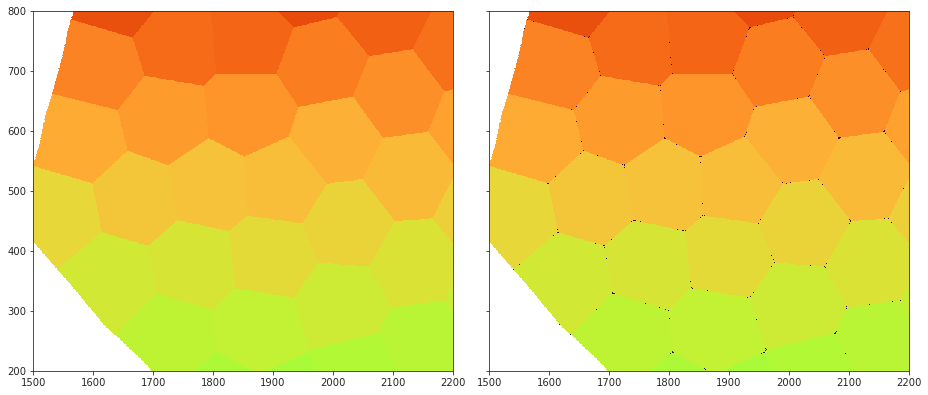

In [17]:
fig, axes = create_figure(1, 2, (13, 6), True, True)
axes[0].imshow(np.ma.masked_where(al.lookup == 0, parc['parcel'].squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(al.lookup == 0, parc['eroded'].squeeze()), cmap='turbo')

axes[1].set(xlim=(1500, 2200), ylim=(200, 800))

In [18]:
from skimage.feature import canny

In [21]:
contour = parc['parcel'].squeeze().astype(float)
contour = canny(contour, sigma=1e-10)

[(100.0, 700.0), (500.0, 800.0)]

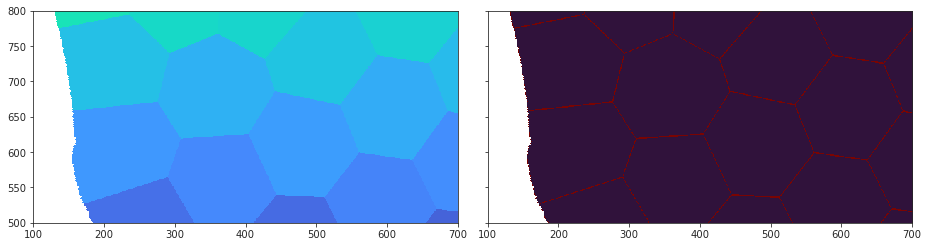

In [26]:
fig, axes = create_figure(1, 2, (13, 6), True, True)
axes[0].imshow(np.ma.masked_where(al.lookup == 0, parc['parcel'].squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(al.lookup == 0, contour), cmap='turbo')

axes[1].set(xlim=(100, 700), ylim=(500, 800))

<matplotlib.image.AxesImage object at 0x7f4a04413f70>

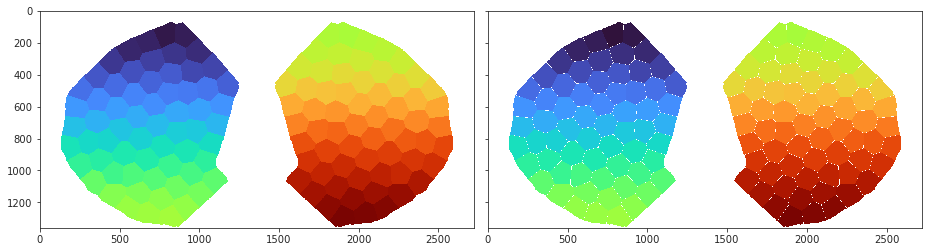

In [27]:
fig, axes = create_figure(1, 2, (13, 6), True, True)
axes[0].imshow(np.ma.masked_where(al.lookup == 0, parc['parcel'].squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(np.logical_or(al.lookup == 0, contour), parc['parcel'].squeeze()), cmap='turbo')

In [29]:
al.id_l, al.id_r

(1, 2)

In [99]:
parcel2d = parc['parcel'].squeeze().copy()
parcel3d = np.zeros(al.template.shape, dtype='uint32')
parcel3d.shape

(1320, 800, 1140)

In [100]:
# for ii in tqdm(np.unique(parcel2d[parcel2d.nonzero()])):
for ii in tqdm(range(1, 64 + 1)):
    idxs = np.where(parcel2d == ii)
    for i in al.lookup[idxs]:
        path = al.paths[i]
        path = path[path.nonzero()]
        for jj, layer in enumerate(np.array_split(path, 4)):
            parcel3d.flat[layer] = ii + jj * 64

  0%|          | 0/64 [00:00<?, ?it/s]

<matplotlib.image.AxesImage object at 0x7f4a046c4370>

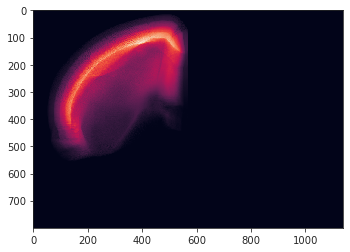

In [61]:
plt.imshow(parcel3d.mean(0))

<matplotlib.image.AxesImage object at 0x7f4a045489a0>

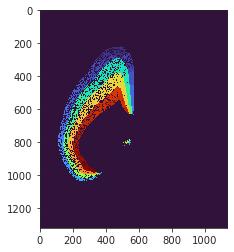

In [62]:
plt.imshow(parcel3d[:, 200, :], cmap='turbo')

<matplotlib.colorbar.Colorbar object at 0x7f4a044d8c40>

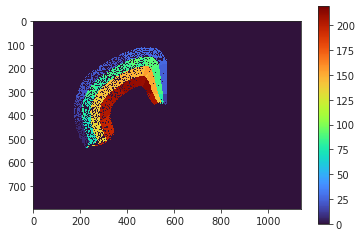

In [63]:
plt.imshow(parcel3d[400], cmap='turbo')
plt.colorbar()

<matplotlib.image.AxesImage object at 0x7f4a045a4250>

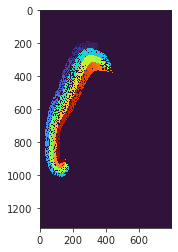

In [64]:
plt.imshow(parcel3d[..., 400], cmap='turbo')

In [65]:
_dir = '/home/hadi/Documents/workspaces/allen/MouseConnectivity/cortical_coordinates/ccf_2017'
laplacian, _ = nrrd.read(pjoin(_dir, 'laplacian_10.nrrd'))

<matplotlib.colorbar.Colorbar object at 0x7f4a0450de50>

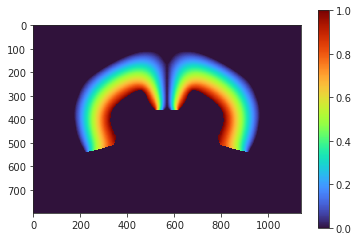

In [66]:
plt.imshow(laplacian[400], cmap='turbo')
plt.colorbar()

In [67]:
laplacian[400][400, 200]

0.1578111

## Fil

<matplotlib.colorbar.Colorbar object at 0x7f456f230130>

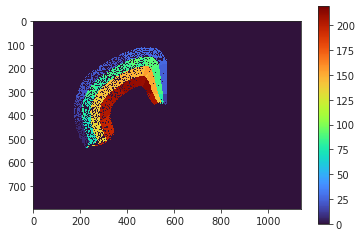

In [101]:
plt.imshow(parcel3d[400], cmap='turbo')
plt.colorbar()

In [102]:
from scipy import ndimage as nd

def fill(data, invalid=None):
    """
    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)
    """

    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

In [119]:
iso_l = al.iso_mask * al.mask_l

<matplotlib.image.AxesImage object at 0x7f43ce325cd0>

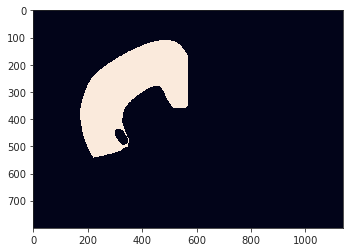

In [120]:
plt.imshow(iso_l[400])

<matplotlib.image.AxesImage object at 0x7f456e46ce50>

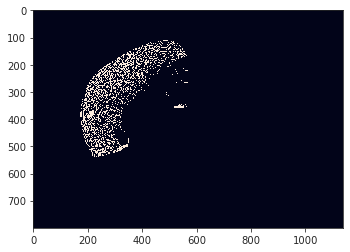

In [123]:
invalid = np.logical_and(parcel3d == 0, iso_l)
plt.imshow(invalid[400])

In [124]:
parcel3d_fill = fill(parcel3d, invalid)

<matplotlib.image.AxesImage object at 0x7f456e3a83d0>

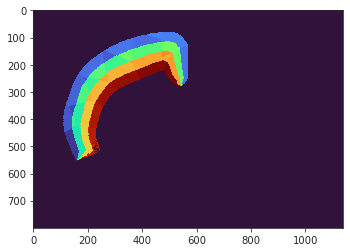

In [128]:
plt.imshow(parcel3d_fill[500], cmap='turbo')

In [126]:
parcel3d_fill.shape

(1320, 800, 1140)

<matplotlib.colorbar.Colorbar object at 0x7f456d1b8400>

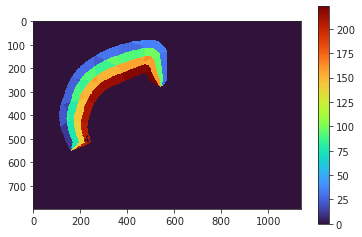

In [243]:
plt.imshow(parcel3d_fill[500], cmap='turbo')
plt.colorbar()

In [251]:
parcel3d_fill_fx = parcel3d_fill.copy()
parcel3d_fill_fx[~al.iso_mask] = 0

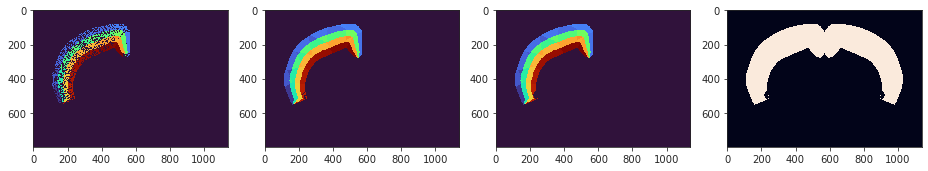

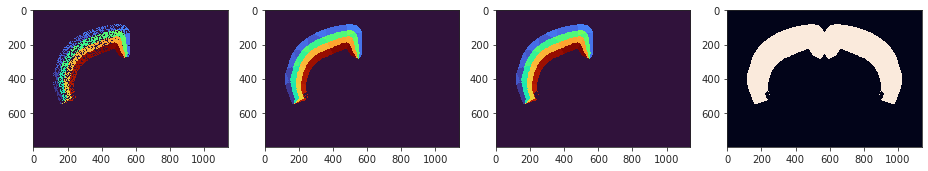

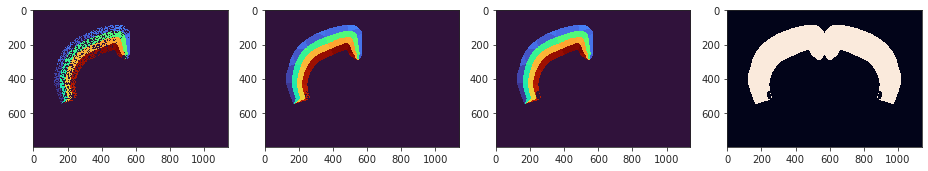

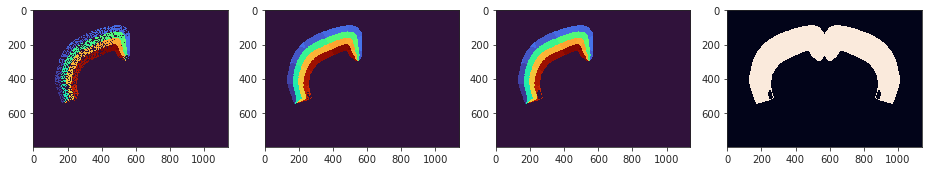

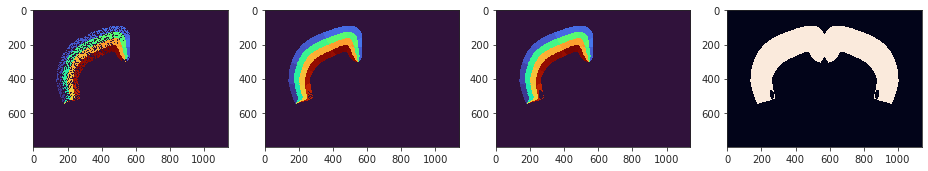

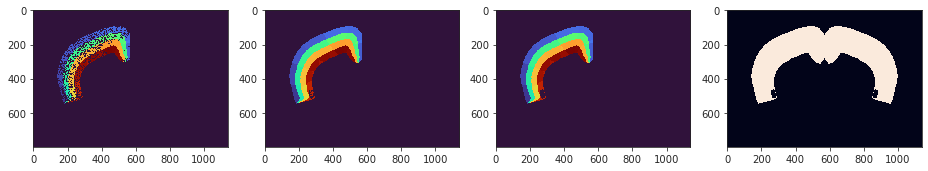

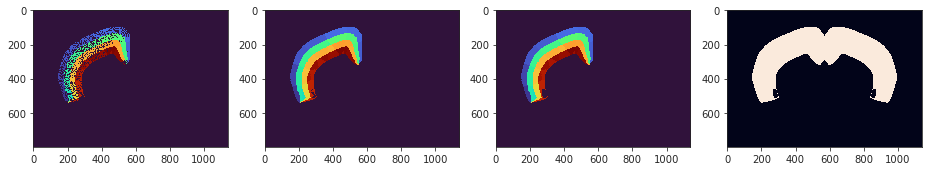

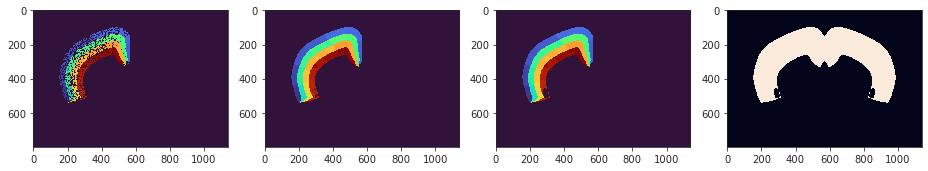

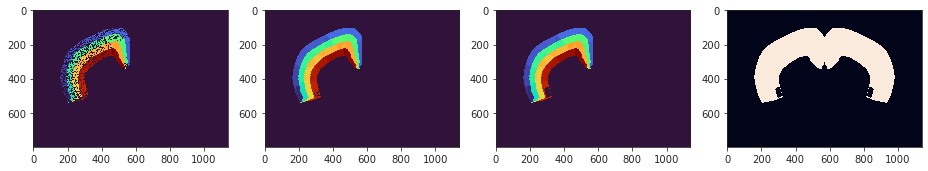

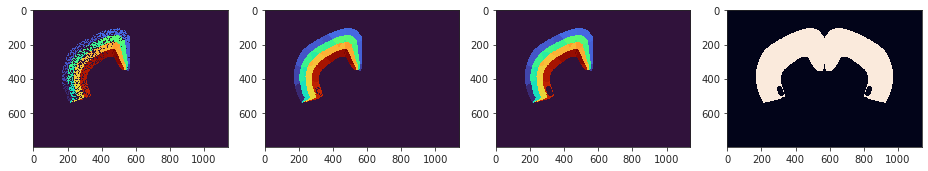

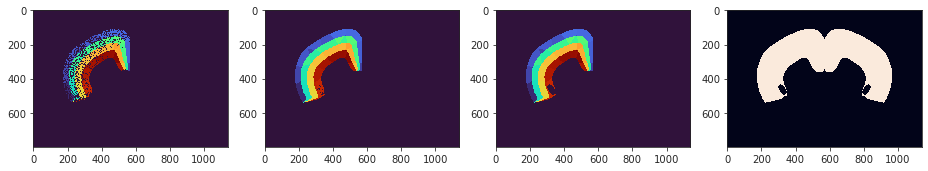

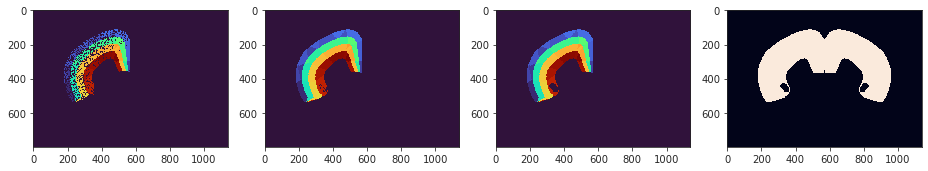

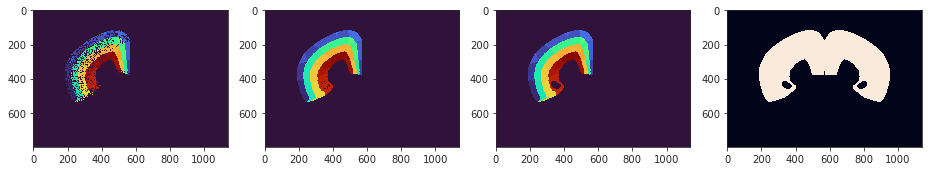

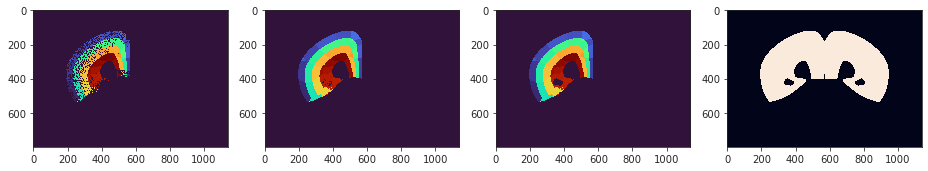

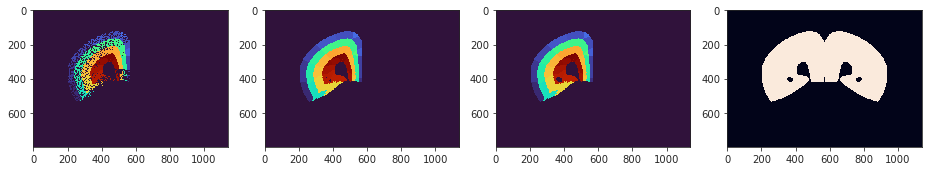

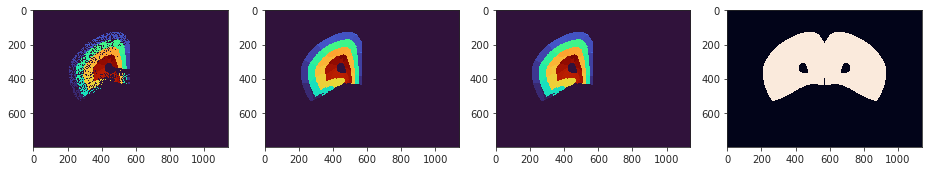

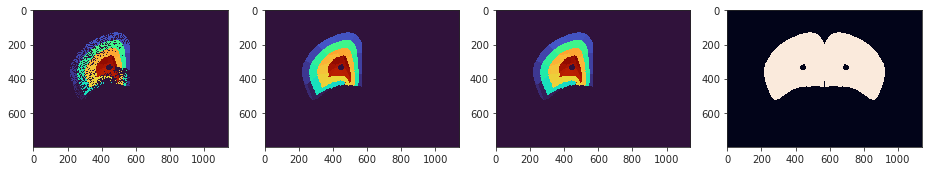

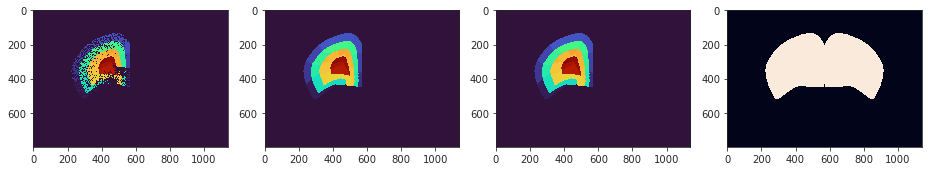

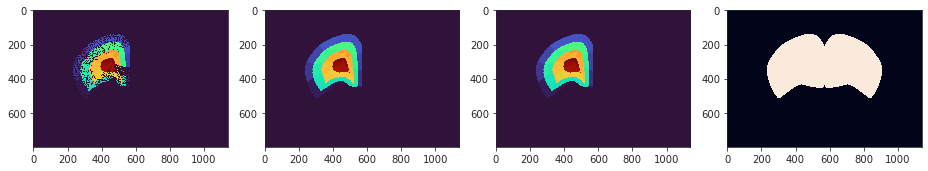

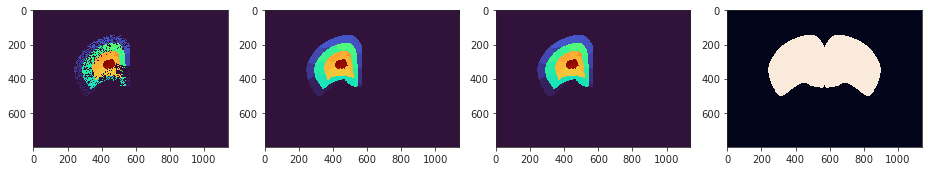

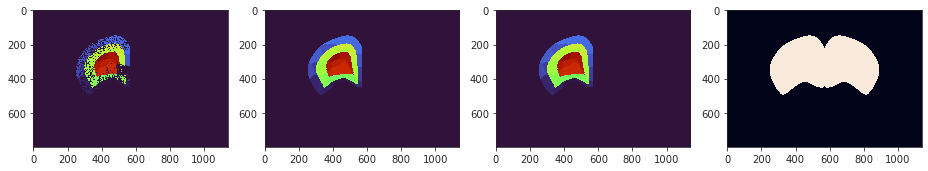

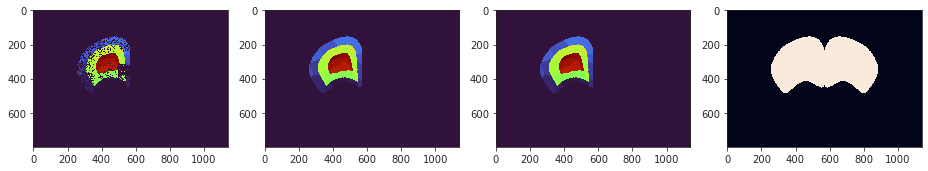

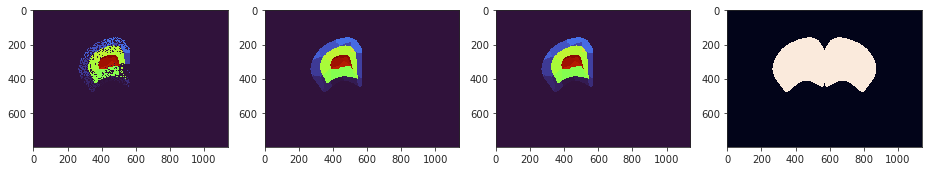

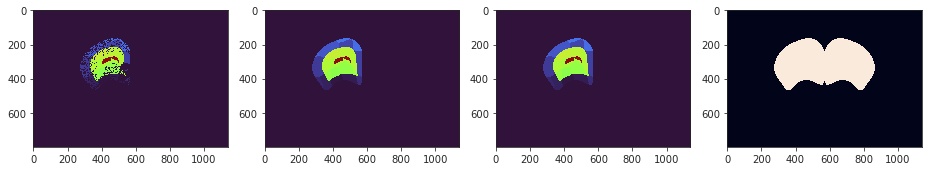

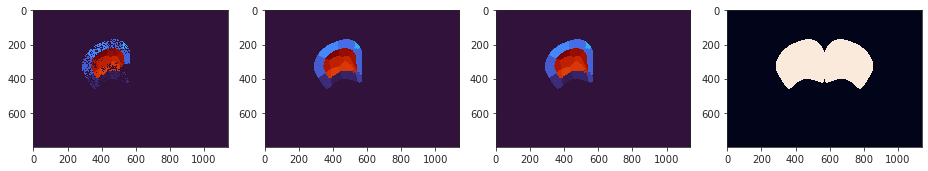

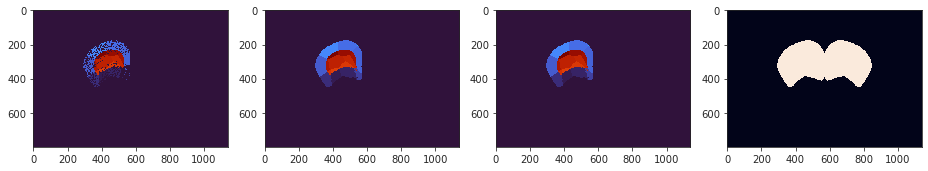

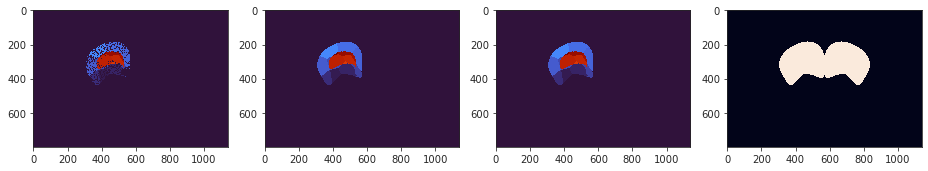

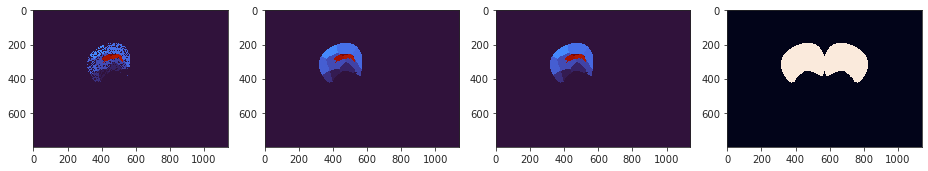

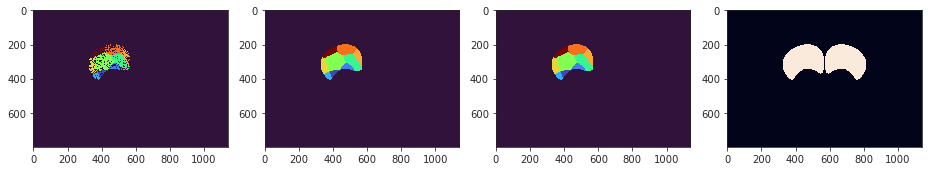

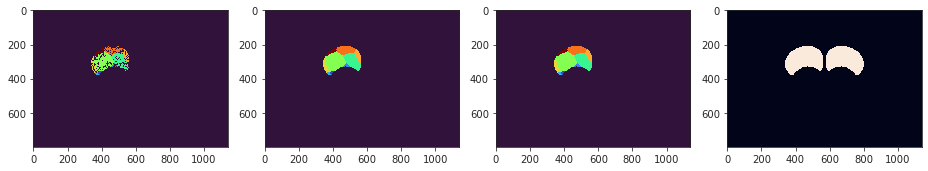

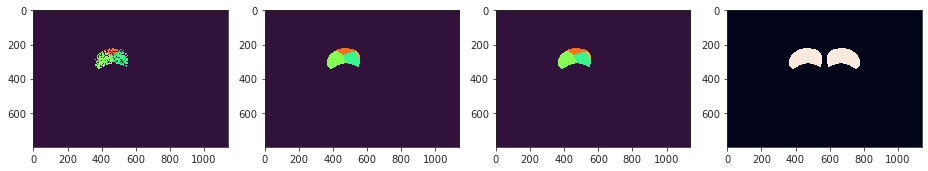

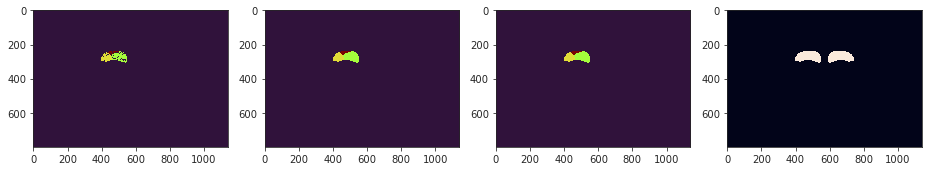

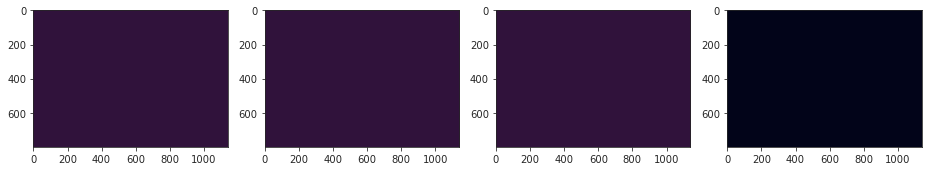

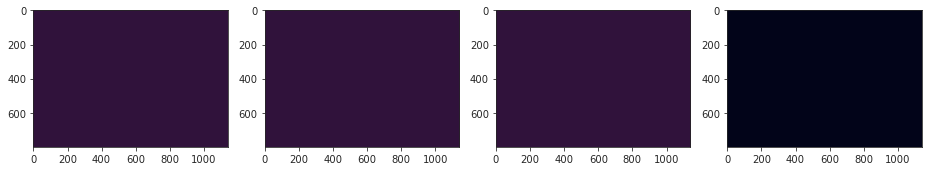

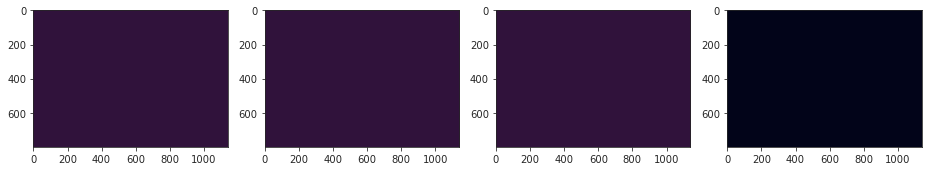

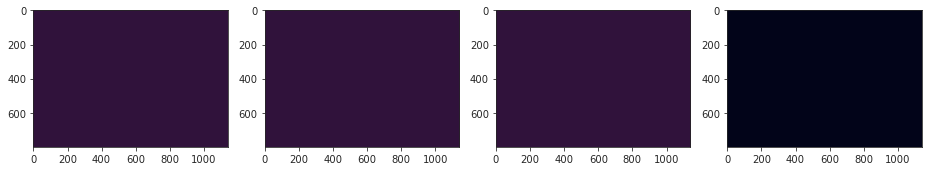

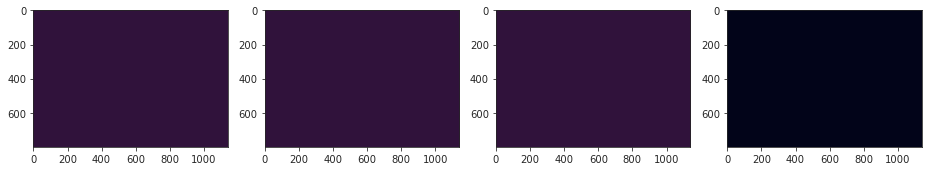

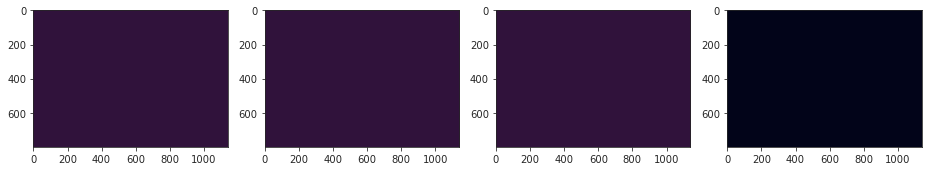

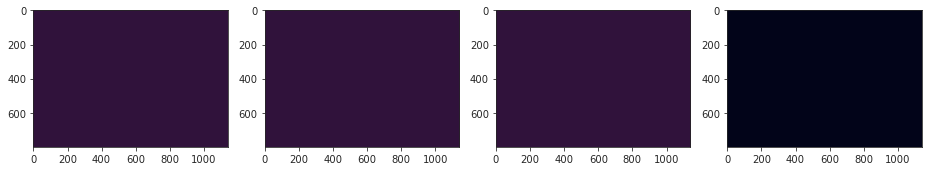

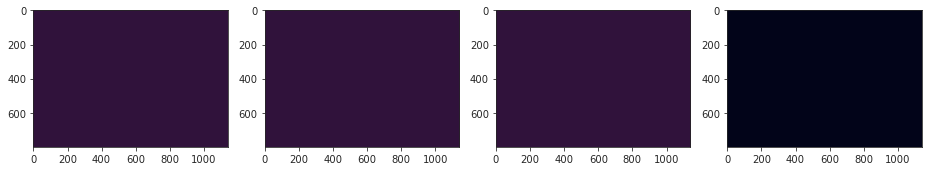

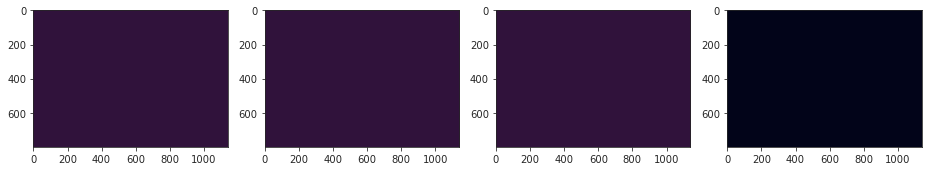

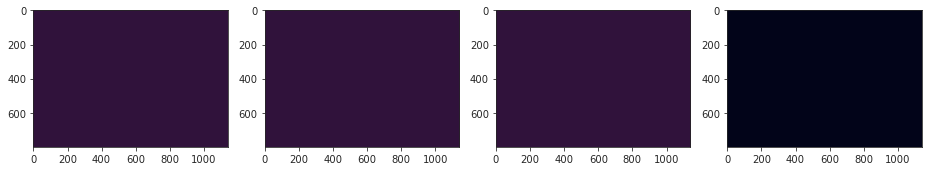

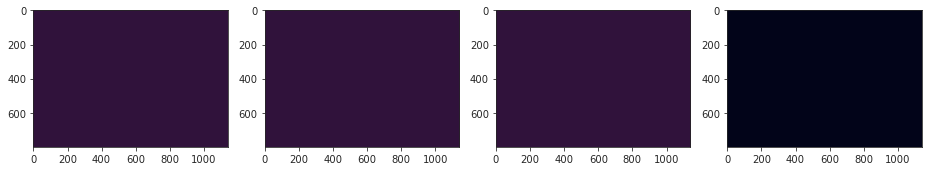

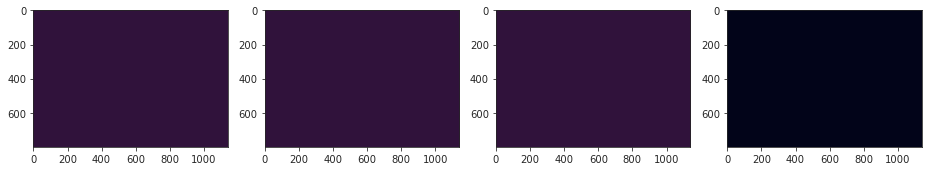

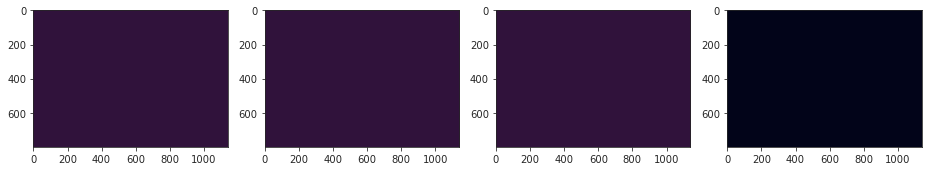

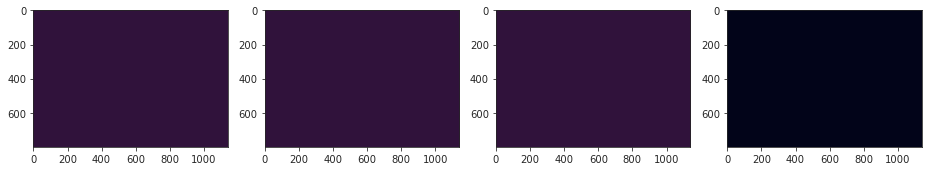

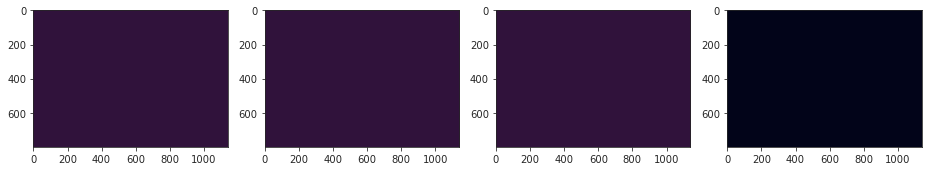

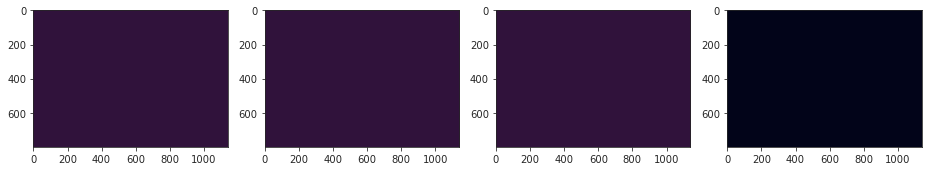

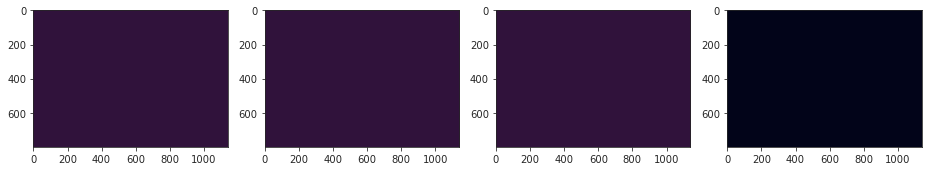

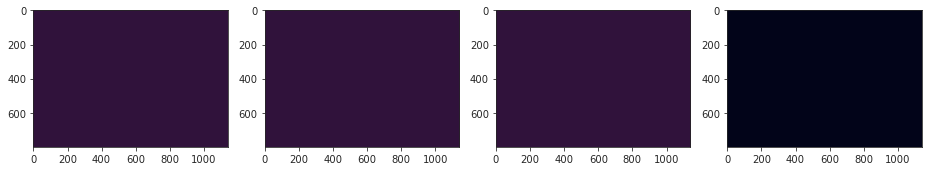

In [256]:
for i in range(50):
    fig, axes = create_figure(1, 4, (13, 6))
    axes[0].imshow(parcel3d[500 - i * 10], cmap='turbo')
    axes[1].imshow(parcel3d_fill[500 - i * 10], cmap='turbo')
    axes[2].imshow(parcel3d_fill_fx[500 - i * 10], cmap='turbo')
    axes[3].imshow(al.iso_mask[500 - i * 10])
    plt.show()

In [210]:
from skimage.measure import block_reduce

In [241]:
parcel3d_reduc = block_reduce(parcel3d_fill, (2, 2, 2), func=np.max)

In [242]:
parcel3d_reduc.dtype, parcel3d_reduc.shape

(dtype('uint32'), (660, 400, 570))

<matplotlib.colorbar.Colorbar object at 0x7f452436da00>

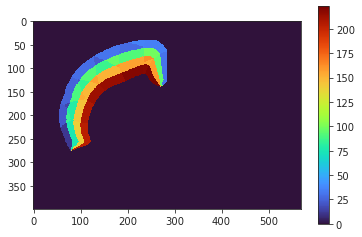

In [245]:
plt.imshow(parcel3d_reduc[250], cmap='turbo')
plt.colorbar()

In [246]:
len(np.unique(parcel3d_reduc[parcel3d_reduc.nonzero()]))

256

In [247]:
len(np.unique(parcel3d[parcel3d.nonzero()]))

256

In [248]:
from skimage.transform import resize

reduced_shape = tuple(int(e / 25 * 10) for e in parcel3d.shape)
parcel3d_resized = resize(
    image=parcel3d_reduc,
    output_shape=reduced_shape,
    anti_aliasing=True,
    preserve_range=True,
)

<matplotlib.colorbar.Colorbar object at 0x7f456cd9cbe0>

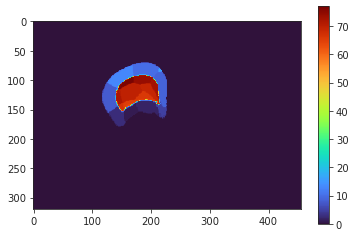

In [249]:
plt.imshow(parcel3d_resized[100], cmap='turbo')
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f456d8a8670>

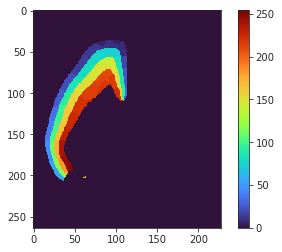

In [159]:
plt.imshow(parcel3d_reduc[:, 50, :], cmap='turbo')
plt.colorbar()

[<matplotlib.lines.Line2D object at 0x7f456d6bc0a0>]

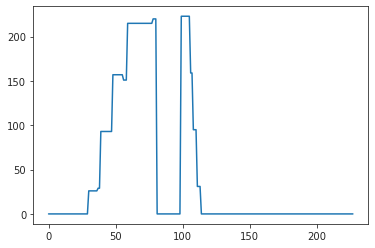

In [162]:
plt.plot(parcel3d_reduc[:, 50, :][100])

In [164]:
np.unique(parcel3d_reduc[:, 50, :])

array([  0,   5,   6,   9,  10,  13,  14,  15,  18,  21,  24,  26,  29,
        31,  34,  38,  46,  55,  62,  73,  74,  77,  79,  82,  84,  85,
        87,  88,  90,  93,  95,  98, 102, 110, 119, 126, 138, 141, 143,
       146, 147, 148, 149, 151, 152, 157, 159, 162, 166, 174, 183, 187,
       190, 210, 211, 212, 215, 216, 219, 220, 221, 223, 224, 226, 229,
       230, 238, 242, 247, 251, 254], dtype=uint32)

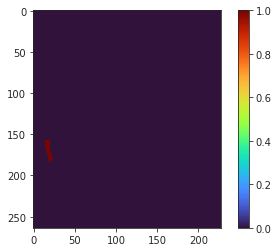

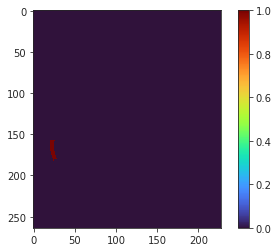

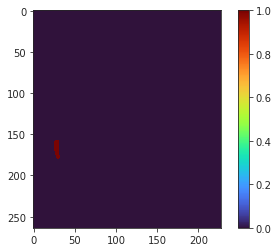

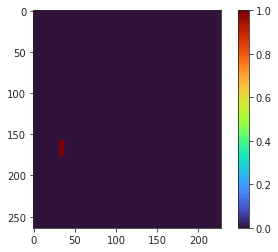

In [171]:
for i in range(4):
    plt.imshow(parcel3d_reduc[:, 50, :] == (46 + i * 64), cmap='turbo')
    plt.colorbar()
    plt.show()

In [179]:
from skimage.transform import resize

reduced_shape = tuple(int(e / 25 * 10) for e in parcel3d.shape)
parcel3d_resized = resize(parcel3d, reduced_shape)

In [183]:
from register.register import reset_ants_img, ants

In [185]:
parcel3d_img = reset_ants_img(parcel3d, spacing=10)
parcel3d_img

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (1320, 800, 1140)
         Spacing    : (10.0, 10.0, 10.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [191]:
al25 = Allen(25, full_load=True)
template25 = reset_ants_img(al25.template.astype('uint32'), spacing=25)

In [206]:
parcel3d_img25 = ants.resample_image_to_target(
    image=parcel3d_img,
    target=template25,
    interp_type='genericLabel',
)

In [207]:
parcel3d_img25

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (528, 320, 456)
         Spacing    : (25.0, 25.0, 25.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7f455ccd8670>

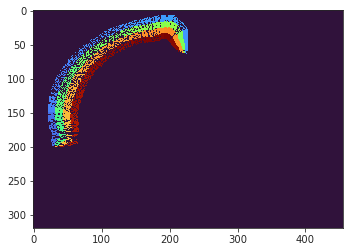

In [208]:
plt.imshow(parcel3d_img25[300], cmap='turbo')

In [ ]:
import numpy as np
from scipy import ndimage as nd

def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)
    Output: 
        Return a filled array. 
    """
    #import numpy as np
    #import scipy.ndimage as nd

    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

In [69]:
parcel2d = parc['parcel'].squeeze().copy()
parcel3d = np.zeros(al.template.shape, dtype='uint32')
parcel3d.shape

(1320, 800, 1140)

In [70]:
ii = 30
idxs = np.where(parcel2d == ii)

points = []
for i in al.lookup[idxs]:
    path = al.paths[i]
    path = path[path.nonzero()]
    
    for jj, layer in enumerate(np.array_split(path, 4)):
        if jj == 0:
            points.extend(list(layer))
points = [np.unravel_index(p, parcel3d.shape) for p in points]
points = [np.reshape(p, (1, -1)) for p in points]
points = np.concatenate(points)
points.shape

(527317, 3)

In [71]:
from scipy.spatial import Delaunay

In [72]:
tri = Delaunay(points)

In [88]:
tri.equations.shape

(2147339, 5)

In [96]:
tri.lift_points(points[0])

array([619.        , 414.        ,  75.        , 275.50114457])

In [97]:
points[0]

array([619, 414,  75])

In [73]:
tri.find_simplex([5120, 20423, 2302303])

array(-1, dtype=int32)

In [76]:
dim = points.shape[-1]
bounday_points = {i: (points[:, i].min(), points[:, i].max()) for i in range(dim)}
delta = {i: b - a for i, (a, b) in bounday_points.items()}
bounday_points, delta

({0: (578, 726), 1: (263, 416), 2: (58, 134)}, {0: 148, 1: 153, 2: 76})

In [79]:
min_x = points[:, 0].min()
min_y = points[:, 1].min()
min_z = points[:, 2].min()
max_x = points[:, 0].max()
max_y = points[:, 1].max()
max_z = points[:, 2].max()
delta = (
    max_x - min_x,
    max_y - min_y,
    max_z - min_z,
)
(min_x, max_x), (min_y, max_y), (min_z, max_z)

((578, 726), (263, 416), (58, 134))

In [80]:
delta

(148, 153, 76)

In [85]:
eps = 0.0
enclosure = {
    i: (a - int(eps * delta[i]), b + int(eps * delta[i]))
    for i, (a, b) in bounday_points.items()
}
enclosure

{0: (578, 726), 1: (263, 416), 2: (58, 134)}

In [86]:
extra_points = []
for i in range(enclosure[0][0], vol[0][1] + 1):
    for j in range(enclosure[1][0], vol[1][1] + 1):
        for k in range(enclosure[2][0], vol[2][1] + 1):
            extra_points.append((i, j, k))

extra_points = [np.reshape(p, (1, -1)) for p in extra_points]
extra_points = np.concatenate(extra_points)
extra_points.shape

(2313948, 3)

In [ ]:
%%time
is_hull = tri.find_simplex(extra_points)

In [ ]:
is_hull.shape

In [ ]:
from scipy.optimize import linprog

def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

n_points = 10000
n_dim = 10
Z = np.random.rand(n_points,n_dim)
x = np.random.rand(n_dim)
print(in_hull(Z, x))

In [ ]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [62]:
list(parc)

['parcel', 'eroded', 'cluster_centers', 'mask_l', 'mask_r', 'radius']

In [67]:
parcel = parc['parcel'] * parc['mask_l']
parcel = parcel.squeeze()

<matplotlib.image.AxesImage object at 0x7f82283fd9a0>

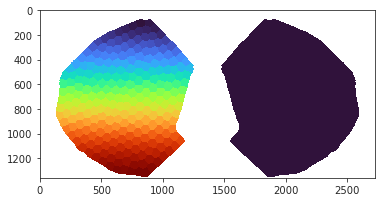

In [68]:
plt.imshow(np.ma.masked_where(al.lookup == 0, parcel), cmap='turbo')

In [79]:
def apply_along_path(i):
    path = al.paths[i]
    path = path[path.nonzero()]
    arr = al.template.flat[path]
    return np.max(arr)

result = np.zeros(al.lookup.shape, dtype=al.template.dtype)
apply_along_paths_ = np.vectorize(apply_along_path)

idx = np.where((al.lookup > 0) * parc['mask_l'].squeeze())
result[idx] = apply_along_paths_(al.lookup[idx])

In [80]:
result.shape

(1360, 2720)

<matplotlib.image.AxesImage object at 0x7f8220376fd0>

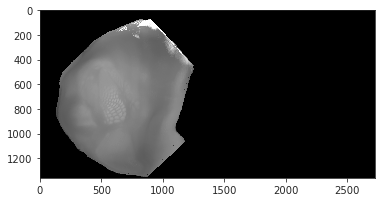

In [81]:
plt.imshow(result, cmap='Greys_r')

<matplotlib.image.AxesImage object at 0x7f8228277c70>

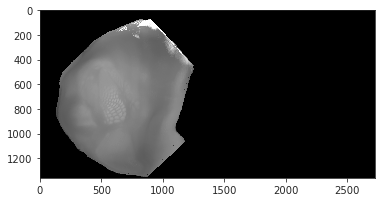

In [78]:
plt.imshow(result, cmap='Greys_r')

In [82]:
np.unique(parcel[parcel.nonzero()])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256], dtype=uint32)

In [83]:
256 * 3


768

In [108]:
al.cm_paths.shape

(713732, 200)

In [109]:
path = al.cm_paths[25]
path

array([165362060, 166275200, 167187200, 168099200, 169011200, 169924340,
       170836340, 171748340, 171748340, 172661480, 173573480, 174485479,
       175397479, 176309479, 177222619, 178134619, 179046619, 179958619,
       180870619, 181783758, 182695758, 183607758, 184519758, 185431758,
       186344898, 187256897, 188168897, 189080897, 189992897, 190906037,
       191818036, 192730036, 193642036, 194554036, 195466035, 196379175,
       196379175, 197291175, 198203174, 199115174, 200028314, 200940314,
       201852313, 202764313, 203676313, 204589453, 205501452, 206413452,
       207325452, 208237451, 209150591, 210062591, 210974591, 210974590,
       211886590, 212799730, 213711729, 214623729, 215535729, 216447728,
       217360868, 218272868, 219184867, 220096867, 221008867, 221922006,
       222834006, 222834006, 223746005, 224658005, 225571145, 226483144,
       227395144, 228307144, 229219143, 230132283, 231044283, 231956282,
       231956282, 232869422, 233781421, 234693421, 235605421, 236518560,
       237430560, 238342559, 239254559, 240166559, 241079698, 241079698,
       241991698, 242903697, 243816837, 244728837, 245640836, 246552836,
       247465975, 248377975, 248377975, 249289974, 250203114, 251115114,
       252027113, 252940253, 253852253, 254764252, 255676252, 255677391,
       256589391, 257501391, 258414530, 259326530, 260238530, 261150529,
       262063669, 262975669, 262975668, 263888808, 264800808, 265712807,
       266625947, 267537947, 268449946, 269363086, 269363085, 270275085,
       271188225, 272100224, 273013364, 273925364, 274837363, 275750503,
       275750503, 276662503, 277575642, 278487642, 279400782, 280312781,
       281224781, 281225921, 282137920, 283051060, 283963060, 284875059,
       285788199, 286700199, 286701339, 287613338, 288526478, 289438478,
       290351617, 291263617, 292176757, 292176757, 293088756, 294001896,
       294913896, 295827036, 296739035, 296740175, 297652175, 298565315,
       299478454, 300390454, 300391594, 301303594, 302216733, 303128733,
       304041873, 304041873, 304955013, 305868152, 306780152, 306781292,
       307693292, 308606432, 309519571, 309519571, 310432711, 311345851,
       312257851, 312258991, 313172130, 314085270, 314085270,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0], dtype=int32)

In [110]:
path = path[path.nonzero()]
path

array([165362060, 166275200, 167187200, 168099200, 169011200, 169924340,
       170836340, 171748340, 171748340, 172661480, 173573480, 174485479,
       175397479, 176309479, 177222619, 178134619, 179046619, 179958619,
       180870619, 181783758, 182695758, 183607758, 184519758, 185431758,
       186344898, 187256897, 188168897, 189080897, 189992897, 190906037,
       191818036, 192730036, 193642036, 194554036, 195466035, 196379175,
       196379175, 197291175, 198203174, 199115174, 200028314, 200940314,
       201852313, 202764313, 203676313, 204589453, 205501452, 206413452,
       207325452, 208237451, 209150591, 210062591, 210974591, 210974590,
       211886590, 212799730, 213711729, 214623729, 215535729, 216447728,
       217360868, 218272868, 219184867, 220096867, 221008867, 221922006,
       222834006, 222834006, 223746005, 224658005, 225571145, 226483144,
       227395144, 228307144, 229219143, 230132283, 231044283, 231956282,
       231956282, 232869422, 233781421, 234693421, 235605421, 236518560,
       237430560, 238342559, 239254559, 240166559, 241079698, 241079698,
       241991698, 242903697, 243816837, 244728837, 245640836, 246552836,
       247465975, 248377975, 248377975, 249289974, 250203114, 251115114,
       252027113, 252940253, 253852253, 254764252, 255676252, 255677391,
       256589391, 257501391, 258414530, 259326530, 260238530, 261150529,
       262063669, 262975669, 262975668, 263888808, 264800808, 265712807,
       266625947, 267537947, 268449946, 269363086, 269363085, 270275085,
       271188225, 272100224, 273013364, 273925364, 274837363, 275750503,
       275750503, 276662503, 277575642, 278487642, 279400782, 280312781,
       281224781, 281225921, 282137920, 283051060, 283963060, 284875059,
       285788199, 286700199, 286701339, 287613338, 288526478, 289438478,
       290351617, 291263617, 292176757, 292176757, 293088756, 294001896,
       294913896, 295827036, 296739035, 296740175, 297652175, 298565315,
       299478454, 300390454, 300391594, 301303594, 302216733, 303128733,
       304041873, 304041873, 304955013, 305868152, 306780152, 306781292,
       307693292, 308606432, 309519571, 309519571, 310432711, 311345851,
       312257851, 312258991, 313172130, 314085270, 314085270], dtype=int32)

<AxesSubplot:ylabel='Count'>

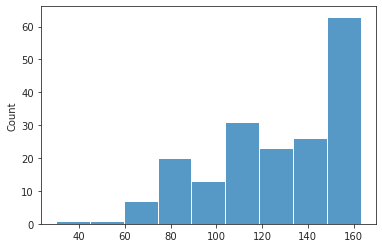

In [111]:
sns.histplot(al.template.flat[path])

In [113]:
np.unravel_index(path, al.template.shape)

(
    array([181, 182, 183, 184, 185, 186, 187, 188, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 264, 265,
       266, 267, 268, 269, 270, 271, 272, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 280, 281, 282, 283, 284, 285, 286, 287, 288, 288,
       289, 290, 291, 292, 293, 294, 295, 295, 296, 297, 298, 299, 300,
       301, 302, 302, 303, 304, 305, 306, 307, 308, 308, 309, 310, 311,
       312, 313, 314, 314, 315, 316, 317, 318, 319, 320, 320, 321, 322,
       323, 324, 325, 325, 326, 327, 328, 329, 329, 330, 331, 332, 333,
       333, 334, 335, 336, 336, 337, 338, 339, 339, 340, 341, 342, 342,
       343, 344, 344]),
    array([254, 255, 255, 255, 255, 256, 256, 256, 256, 257, 257, 257, 257,
       257, 258, 258, 258, 258, 258, 259, 259, 259, 259, 259, 260, 260,
       260, 260, 260, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262,
       262, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264, 265, 265,
       265, 265, 265, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267,
       268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 270, 270, 270,
       270, 271, 271, 271, 271, 272, 272, 272, 272, 272, 273, 273, 273,
       273, 274, 274, 274, 274, 275, 275, 275, 275, 276, 276, 276, 277,
       277, 277, 277, 278, 278, 278, 279, 279, 279, 279, 280, 280, 280,
       281, 281, 281, 282, 282, 282, 283, 283, 283, 284, 284, 285, 285,
       285, 286, 286, 286, 287, 287, 288, 288, 288, 289, 289, 290, 290,
       290, 291, 291, 292, 292, 293, 293, 294, 294, 295, 295, 295, 296,
       296, 297, 297, 298, 298, 299, 300, 300, 301, 301, 302, 302, 303,
       303, 304, 305, 305, 306, 306, 307, 308, 308, 309, 310, 310, 311,
       312, 313, 313]),
    array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 499, 499,
       499, 499, 499, 499, 499, 499, 498, 498, 498, 498, 498, 498, 497,
       497, 497, 497, 497, 496, 496, 496, 496, 495, 495, 495, 495, 494,
       494, 494, 494, 493, 493, 493, 493, 492, 492, 492, 491, 491, 491,
       491, 490, 490, 490, 489, 489, 489, 488, 488, 488, 487, 487, 487,
       486, 486, 486, 485, 485, 485, 484, 484, 484, 483, 483, 483, 482,
       482, 482, 481, 481, 481, 480, 480, 479, 479, 479, 478, 478, 478,
       477, 477, 477, 476, 476, 475, 475, 475, 474, 474, 474, 473, 473,
       473, 472, 472, 471, 471, 471, 470, 470, 470, 469, 469, 469, 468,
       468, 468, 467, 467, 467, 466, 466, 465, 465, 465, 464, 464, 464,
       463, 463, 463, 463, 462, 462, 462, 461, 461, 461, 460, 460, 460,
       459, 459, 459, 459, 458, 458, 458, 457, 457, 457, 457, 456, 456,
       456, 456, 455, 455, 455, 455, 454, 454, 454, 454, 453, 453, 453,
       453, 453, 452, 452, 452, 452, 452, 451, 451, 451, 451, 451, 451,
       450, 450, 450])
)

In [115]:
al.cm_lookup.shape

(1320, 1140)

<matplotlib.colorbar.Colorbar object at 0x7f8242a29040>

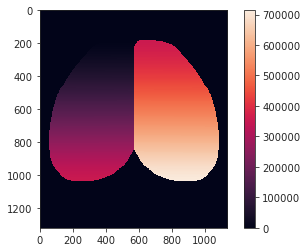

In [118]:
plt.imshow(al.cm_lookup)
plt.colorbar()

<AxesSubplot:ylabel='Count'>

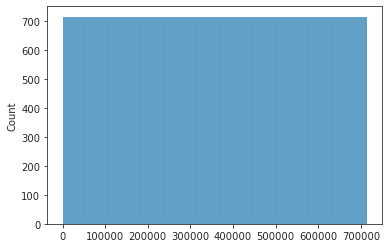

In [121]:
sns.histplot(al.cm_lookup[al.cm_lookup > -1], bins=1000)

In [15]:
y = al.transform(al.nissl, agg_func=np.max)
y.shape

(1320, 1140)

<matplotlib.image.AxesImage object at 0x7edb9c9542e0>

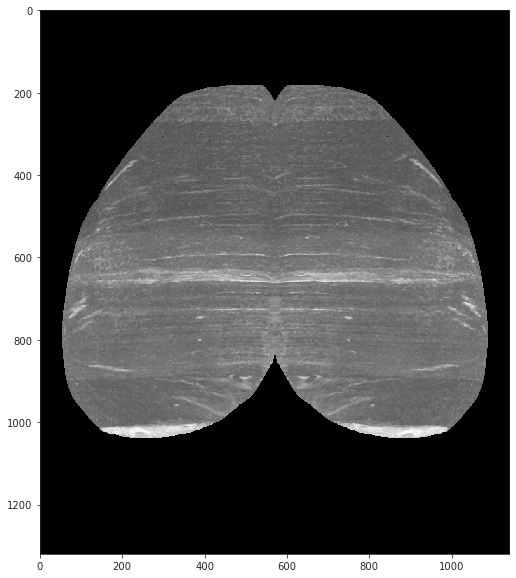

In [617]:
plt.figure(figsize=(15, 10))
plt.imshow(y, cmap='Greys_r')

In [623]:
y.dtype, y.min(), y.max()

(dtype('float32'), 0.0, 22458.041)

In [16]:
x = al.transform(al.template, 'dorsal_flatmap', agg_func=np.max)
x.shape

(1360, 2720)

<matplotlib.image.AxesImage object at 0x7f6e7554cd30>

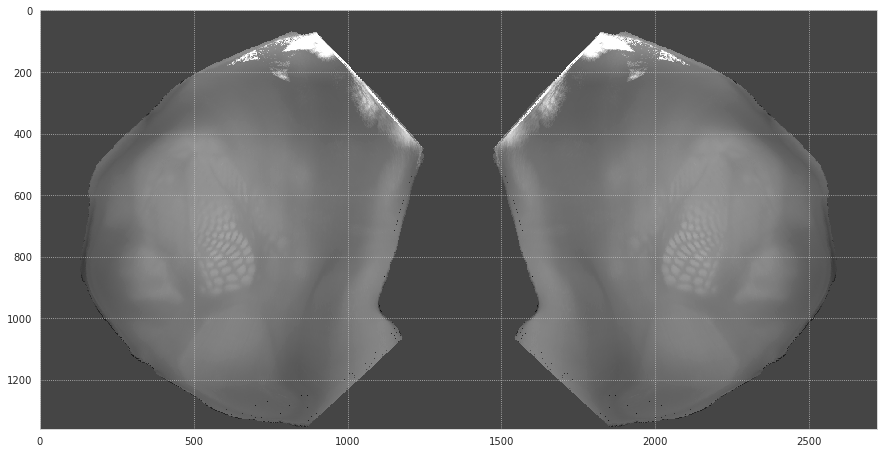

In [17]:
plt.figure(figsize=(15, 10))
plt.imshow(x, cmap='Greys_r')

In [18]:
x.dtype, x.min(), x.max()

(dtype('uint16'), 16, 516)

<matplotlib.image.AxesImage object at 0x7f6e9ea5ba00>

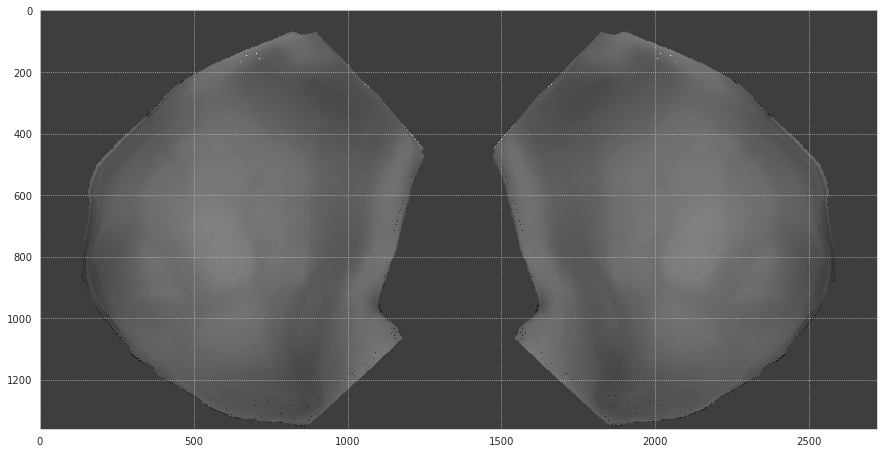

In [19]:
x = al.transform(al.template, 'dorsal_flatmap', agg_func=np.median)
plt.figure(figsize=(15, 10))
plt.imshow(x, cmap='Greys_r')

In [624]:
y = cm.transform(al.nissl, agg_func=np.max)
y.shape

(1360, 2720)

<matplotlib.image.AxesImage object at 0x7edb679be0a0>

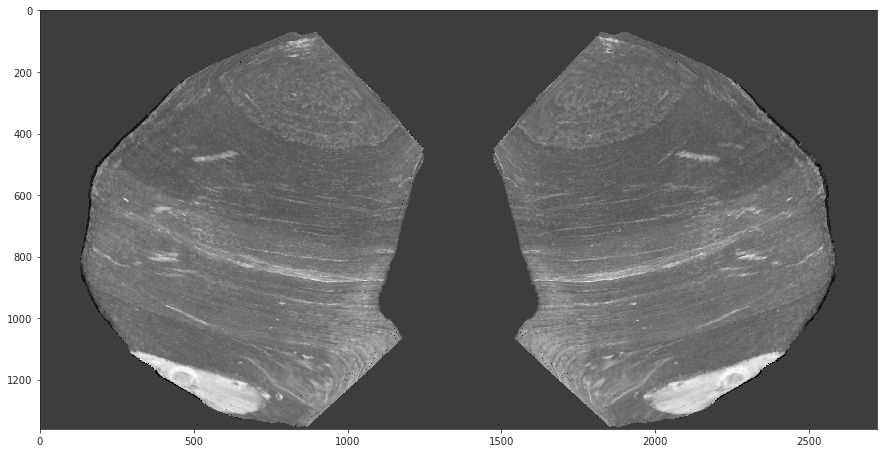

In [625]:
plt.figure(figsize=(15, 10))
plt.imshow(y, cmap='Greys_r')

In [626]:
y.dtype, y.min(), y.max()

(dtype('float32'), 65.002556, 22458.041)